In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install ray
# !pip install tensorboardX

In [ ]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00


In [ ]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import os, random
import math 
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import datetime as dt
from tqdm import tqdm as tq
from numpy import vstack, sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
import matplotlib.patches as mpatches
from google.colab import files
 

from functools import partial
from pylab import rcParams

import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from ray.tune.stopper import TrialPlateauStopper

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 24, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1

**Data Preprocessing**

In [ ]:
data_path = '/content/drive/MyDrive/PhD-Research-Phase-1-2/Data/'

In [ ]:
hurricanefile_nhc = data_path+'hurricane.mat'
hurricane_data_nhc = scipy.io.loadmat(hurricanefile_nhc)
hurricane_nhc = hurricane_data_nhc['hurricane']
hurricanefile = data_path+'hurricane_1.mat'
hurricane_data = scipy.io.loadmat(hurricanefile)
hurricane = hurricane_data['hurricane']
forecasts_data_file = data_path+'forecasts_int.mat'
forecasts_data_mat = scipy.io.loadmat(forecasts_data_file)
nhc_forecasts = forecasts_data_mat['NHC']
nhc_time_split = forecasts_data_mat['time']
model_forecasts = forecasts_data_mat['X']
ground_truths = forecasts_data_mat['Y']
best_track_file = data_path+'best_track.mat'
best_track_matlab_data = scipy.io.loadmat(best_track_file)
best_track = best_track_matlab_data['best_track']

In [ ]:
total_timesteps= 24
train_time_steps = 16
test_time_steps = total_timesteps - train_time_steps
train_test_ratio = 0.8
number_of_hurricanes = best_track[0].shape[0]
number_of_hurricanes

3111

In [ ]:
nhc_hurricane_forecast_dict = {}
nhc_original_dict = {}
test_data_raw = [] 
valid_nhc_forecasts = 0 
for i in range(nhc_time_split.shape[0]):
  nhc_hurricane_timesteps = nhc_time_split[i][1] - nhc_time_split[i][0] + 1
  if  nhc_hurricane_timesteps >= total_timesteps: 
    first_point_index = nhc_time_split[i][0] - 1
    prediction_window_start = first_point_index + train_time_steps - 1 
    nhc_forecast = nhc_forecasts[0,1:,prediction_window_start]
    hurricane_name = hurricane_nhc[0][i][0][0]
    if np.nansum(nhc_forecast) > 0:
      nhc_hurricane_forecast_dict[hurricane_name] = nhc_forecast
      nhc_original_dict[hurricane_name] = nhc_forecasts[0,0,prediction_window_start+1:prediction_window_start+test_time_steps+1]
      test_data_raw.append(nhc_forecasts[0,0,first_point_index:first_point_index+total_timesteps])
      valid_nhc_forecasts +=1
    prediction_window_index = prediction_window_start + test_time_steps
    j=1
    while prediction_window_index + test_time_steps < first_point_index+nhc_hurricane_timesteps:
      nhc_forecast = nhc_forecasts[0,1:,prediction_window_index]
      if np.nansum(nhc_forecast) > 0:
        key = hurricane_name+"_"+str(j+1)
        nhc_hurricane_forecast_dict[key] = nhc_forecast
        nhc_original_dict[key] = nhc_forecasts[0,0,prediction_window_index+1:prediction_window_index+test_time_steps+1]
        test_data_raw.append(nhc_forecasts[0,0,prediction_window_index+test_time_steps+1-total_timesteps:prediction_window_index+1+test_time_steps])
        j+=1
        valid_nhc_forecasts +=1
      prediction_window_index = prediction_window_index + test_time_steps
      
valid_nhc_forecasts
# nhc_hurricane_forecast_dict

212

In [ ]:
total_observations = 0 
hurricane_count = 0
for i in range(number_of_hurricanes):
    per_hurricane_observations = best_track[0][i].shape[0]
    if per_hurricane_observations>=total_timesteps: 
        total_observations = total_observations + per_hurricane_observations - total_timesteps +1
        hurricane_count += 1
print("hurricane_count, total_observations:", hurricane_count, total_observations)

train_data = []
test_data = []
nhc_forecast_max = np.zeros(0)
hurricane_original_best_track= {}
nhc_count = 0 
hurricane_serial=0
for i in range(number_of_hurricanes):    
    per_hurricane_observations = best_track[0][i].shape[0]
    temp = []
    if per_hurricane_observations>=total_timesteps:
        for j in range(per_hurricane_observations):
            intensity = best_track[0][i][j][3]
            if j !=0:
              if intensity  < 0 : intensity = best_track[0][i][j-1][3]
            temp.append(intensity)
#             data[hurricane_serial,j]=intensity
        hurricane_serial+=1
    number_of_observations = len(temp)
    windows = 0
    neg_list = sum(n < 0 for n in temp)
    if neg_list>0: continue
    for k in range(0, number_of_observations+1-total_timesteps, test_time_steps):
        current_data = temp[k:k+total_timesteps]
        if k == 0: 
          hurricane_key = hurricane[0][i][0][0]
        else: hurricane_key = hurricane[0][i][0][0]+"_"+str(windows+1)
        if hurricane_key in nhc_hurricane_forecast_dict:
            nhc_count  +=1
        else: train_data.append(current_data)
        windows +=1 
print("Number of Hurricanes:", hurricane_serial)
print("Number of Hurricanes/Observations matched with NHC forecast:", nhc_count)
print("After moving window, number of train data:", len(train_data))

train_data = np.array(train_data)
test_data = np.array(test_data_raw)
print("Train and Test Data shape before normalizing/standardizing:", train_data.shape, test_data.shape)

scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(train_data.reshape(-1,1))
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()
# data=scaler.fit_transform(data.reshape(-1,1))
train_data = train_data.reshape(-1,total_timesteps)
print("Train Data shape after normalizing/standardizing:", train_data.shape)

test_data=scaler.transform(test_data.reshape(-1,1))
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()
# data=scaler.fit_transform(data.reshape(-1,1))
test_data = test_data.reshape(-1,total_timesteps)
print("Train and Test Data shape before normalizing/standardizing:", train_data.shape, test_data.shape)

hurricane_count, total_observations: 1504 24384
Number of Hurricanes: 1504
Number of Hurricanes/Observations matched with NHC forecast: 212
After moving window, number of train data: 3525
Train and Test Data shape before normalizing/standardizing: (3525, 24) (212, 24)
Train Data shape after normalizing/standardizing: (3525, 24)
Train and Test Data shape before normalizing/standardizing: (3525, 24) (212, 24)


**Train, Validate, Test Data**

In [ ]:
# ##splitting dataset into train and test split
# training_size=int(data.shape[0]*train_test_ratio)
# test_size=data.shape[0]-training_size
# train_data,test_data=data[0:training_size,:],data[training_size:data.shape[0],:]
print("Before Validation Data: train vs test", train_data.shape, test_data.shape)

length = int(len(train_data)*0.8)
random.shuffle(train_data)
val_data= train_data[length:]
train_data = train_data[0:length]
print("After Validation Data (from train data): train vs validation vs test", train_data.shape, val_data.shape, test_data.shape)

Before Validation Data: train vs test (3525, 24) (212, 24)
After Validation Data (from train data): train vs validation vs test (2820, 24) (705, 24) (212, 24)


**Data Creation**

In [ ]:
batch_size =64
def extend_last_batch(X, y, batch_size=batch_size):
    last_batch_size = X.shape[0] % batch_size
    if last_batch_size != 0:
        indices = [i for i in range(0, (y.shape[0]-last_batch_size))]

        index = random.sample(indices, batch_size - last_batch_size)
        X_extended = X[index]
        y_extended = y[index]
        X = torch.cat((X, X_extended), 0)
        y = torch.cat((y, y_extended), 0)
    return X, y

In [ ]:
def create_X_data(dataset, time_step=1):
    dataX = []
    for i in range(len(dataset)):
        X_data = dataset[i][0:time_step]
        dataX.append(X_data)
    return np.array(dataX)

def ready_X_data(train_data, val_data, test_data, train_time_steps):
      X_train = create_X_data(train_data, train_time_steps)
      X_val = create_X_data(val_data, train_time_steps)
      X_test = create_X_data(test_data, train_time_steps) 
      # reshape input to be [samples, time steps, features] which is required for LSTM
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_val =X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      
      X_train = torch.from_numpy(X_train).float().to(device)
      X_val = torch.from_numpy(X_val).float().to(device)
      X_test = torch.from_numpy(X_test).float().to(device)
     
      return X_train, X_val , X_test

In [ ]:
def create_y_data(dataset, time_step=1, mode = "max_only"):
    dataY = []
    for i in range(len(dataset)):
        if mode == "max_only": y_data = np.max(dataset[i][time_step:])
        elif mode == "all": y_data=(dataset[i][time_step:])
        elif mode == "all_max": 
            y_data_1 =(dataset[i][time_step:])
            y_data_2 = np.max(dataset[i][time_step:])
            y_data = np.hstack((y_data_1,y_data_2))
        dataY.append(y_data)
    return np.array(dataY)

def ready_y_data(train_data, val_data, test_data, train_time_steps, mode = "max_only"):
      y_train = create_y_data(train_data, train_time_steps, mode)
      y_val = create_y_data(val_data, train_time_steps, mode)
      y_test = create_y_data(test_data, train_time_steps, mode )
      if mode == "max_only":
          y_train =y_train.reshape(-1 , 1)
          y_val =y_val.reshape(-1 , 1)
          y_test = y_test.reshape(-1, 1)
      else: 
          y_train =y_train.reshape(-1 , y_train.shape[1], 1)
          y_val =y_val.reshape(-1 , y_train.shape[1], 1)
          y_test = y_test.reshape(-1, y_train.shape[1], 1)

      y_train = torch.from_numpy(y_train).float().to(device)
      y_val = torch.from_numpy(y_val).float().to(device)
      y_test = torch.from_numpy(y_test).float().to(device)

      return y_train , y_val, y_test 


In [ ]:
X_train, X_val, X_test = ready_X_data(train_data, val_data, test_data, train_time_steps)
y_train_max , y_val_max, y_test_max  = ready_y_data(train_data, val_data, test_data, train_time_steps, mode = "max_only")
y_train_all , y_val_all, y_test_all  = ready_y_data(train_data, val_data, test_data, train_time_steps, mode = "all")
y_train_all_max , y_val_all_max, y_test_all_max  = ready_y_data(train_data, val_data, test_data, train_time_steps, mode = "all_max")

X_train_max, y_train_max = extend_last_batch(X_train, y_train_max)
X_val_max, y_val_max = extend_last_batch(X_val, y_val_max)
X_test_max, y_test_max = extend_last_batch(X_test, y_test_max)

X_train_all, y_train_all = extend_last_batch(X_train, y_train_all)
X_val_all, y_val_all = extend_last_batch(X_val, y_val_all)
X_test_all, y_test_all = extend_last_batch(X_test, y_test_all)

X_train_all_max, y_train_all_max = extend_last_batch(X_train, y_train_all_max)
X_val_all_max, y_val_all_max = extend_last_batch(X_val, y_val_all_max)
X_test_all_max, y_test_all_max = extend_last_batch(X_test, y_test_all_max)

X_train_full_max = torch.cat((X_train_max, X_val_max), 0).to(device)
y_train_full_max = torch.cat((y_train_max, y_val_max), 0).to(device)

X_train_full_all = torch.cat((X_train_all, X_val_all), 0).to(device)
y_train_full_all = torch.cat((y_train_all, y_val_all), 0).to(device)

X_train_full_all_max = torch.cat((X_train_all_max, X_val_all_max), 0).to(device)
y_train_full_all_max = torch.cat((y_train_all_max, y_val_all_max), 0).to(device)

X_train_all.shape, X_train_all_max.shape, X_train_max.shape, y_train_all.shape, y_train_all_max.shape, y_train_max.shape

(torch.Size([2880, 16, 1]),
 torch.Size([2880, 16, 1]),
 torch.Size([2880, 16, 1]),
 torch.Size([2880, 8, 1]),
 torch.Size([2880, 9, 1]),
 torch.Size([2880, 1]))

**Models**

In [ ]:
class FCN_all(nn.Module):
  # output: test_time_steps
  # train_loss: all
  def __init__(self, sequence_len, batch_size, n_hidden=50):
    super(FCN_all, self).__init__()

    self.batch_size = batch_size

    self.linear1 = nn.Linear(in_features=sequence_len, out_features=n_hidden)
    self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linear3 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linearFinal = nn.Linear(in_features=n_hidden, out_features=test_time_steps)

  def forward(self, input_tensor):

      out = self.linear1(input_tensor.view(self.batch_size, -1))
      out = torch.relu(out)
      out = self.linear2(out)
      out = torch.relu(out)
      out = self.linear3(out)
      out = torch.relu(out)
      out = self.linearFinal(out)

      return out

In [ ]:
class LSTM_all(nn.Module):
  # output: test_time_steps
  # train_loss: all
  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(LSTM_all, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)

    self.linear = nn.Linear(in_features=n_hidden*2, out_features=test_time_steps)
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor):

      self.reset_hidden_state()

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden)
      final_out = lstm_out[:, -1, :]
      # print(lstm_out.shape, final_out.shape) -> 64,32,12 -> 64,12
      final_out = self.linear(final_out)
    
      return final_out

In [ ]:
class FCN_all_max(nn.Module):
  # output: test_time_steps + max
  # train_loss: all 
  def __init__(self, sequence_len, batch_size, n_hidden=50):
    super(FCN_all_max, self).__init__()

    self.batch_size = batch_size

    self.linear1 = nn.Linear(in_features=sequence_len, out_features=n_hidden)
    self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linear3 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linearFinal = nn.Linear(in_features=n_hidden, out_features=test_time_steps)

  def forward(self, input_tensor):

      out = self.linear1(input_tensor.view(self.batch_size, -1))
      out = torch.relu(out)
      out = self.linear2(out)
      out = torch.relu(out)
      out = self.linear3(out)
      out = torch.relu(out)
      out = self.linearFinal(out)
      max_node,_= torch.max(out, dim =1)
      final_out= torch.column_stack((out, max_node))

      return final_out

In [ ]:
class LSTM_all_max(nn.Module):
  # output: test_time_steps + max
  # train_loss: all 
  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(LSTM_all_max, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)

    self.linear = nn.Linear(in_features=n_hidden*2, out_features=test_time_steps)
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor):

      self.reset_hidden_state()

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden)
      out = lstm_out[:, -1, :]
      # print(lstm_out.shape, final_out.shape) -> 64,32,12 -> 64,12
      out = self.linear(out)
      max_node,_= torch.max(out, dim =1)
      final_out= torch.column_stack((out, max_node))
    
      return final_out

In [ ]:
class FCN_max(nn.Module):
  # output: max
  # train_loss: max
  def __init__(self, sequence_len, batch_size, n_hidden=50):
    super(FCN_max, self).__init__()

    self.batch_size = batch_size

    self.linear1 = nn.Linear(in_features=sequence_len, out_features=n_hidden)
    self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linear3 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linearFinal = nn.Linear(in_features=n_hidden, out_features=1)

  def forward(self, input_tensor):

      out = self.linear1(input_tensor.view(self.batch_size, -1))
      out = torch.relu(out)
      out = self.linear2(out)
      out = torch.relu(out)
      out = self.linear3(out)
      out = torch.relu(out)
      out = self.linearFinal(out)

      return out

In [ ]:
class FCN_max_all(nn.Module):
  # output: max + all
  # train_loss: max
  def __init__(self, sequence_len, batch_size, n_hidden=50):
    super(FCN_max_all, self).__init__()

    self.batch_size = batch_size

    self.linear1 = nn.Linear(in_features=sequence_len, out_features=n_hidden)
    self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linear3 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linearFinal = nn.Linear(in_features=n_hidden, out_features=test_time_steps)

  def forward(self, input_tensor):

      out = self.linear1(input_tensor.view(self.batch_size, -1))
      out = torch.relu(out)
      out = self.linear2(out)
      out = torch.relu(out)
      out = self.linear3(out)
      out = torch.relu(out)
      out = self.linearFinal(out)
      max_node,_= torch.max(out, dim =1)
      final_out= torch.column_stack((out, max_node))

      return final_out

In [ ]:
class LSTM_max(nn.Module):
  # output: max
  # train_loss: max
  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(LSTM_max, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)

    self.linear = nn.Linear(in_features=n_hidden*2, out_features=1)
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor):

      self.reset_hidden_state()

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden)
      final_out = lstm_out[:, -1, :]
      # print(lstm_out.shape, final_out.shape) -> 64,32,12 -> 64,12
      final_out = self.linear(final_out)
    
      return final_out

In [ ]:
class LSTM_max_all(nn.Module):
  # output: max + all
  # train_loss: max
  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(LSTM_max_all, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)

    self.linear = nn.Linear(in_features=n_hidden*2, out_features=test_time_steps)
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor):

      self.reset_hidden_state()

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden)
      out = lstm_out[:, -1, :]
      # print(lstm_out.shape, final_out.shape) -> 64,32,12 -> 64,12
      out = self.linear(out)
      max_node,_= torch.max(out, dim =1)
      final_out= torch.column_stack((out, max_node))
    
      return final_out

**Parameters Initializations**

In [ ]:
n_features=1
n_hidden =50
n_layers = 4
sequence_len = train_time_steps
lr = 0.01

num_epochs = 15

train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs


**Training Functions**

In [ ]:
def train_model(model_name=None, config=None, checkpoint_dir=None,tuning = True, validation = True, final_train = False, X_train = X_train_max, y_train = y_train_max): 
    if tuning: 
        if model_name=="LSTM_max": 
            model = LSTM_max(n_features, sequence_len, batch_size, config["n_hidden"], config["n_layers"])
        # todo: tune for other models
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    else: 
        if model_name=="LSTM_max": 
            model = LSTM_max(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "FCN_max":
            model = FCN_max(sequence_len, batch_size, n_hidden)
        elif model_name=="LSTM_max_all": 
            model = LSTM_max_all(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "FCN_max_all":
            model = FCN_max_all(sequence_len, batch_size, n_hidden)
        elif model_name == "LSTM_all":
            model = LSTM_all(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "FCN_all":
            model = FCN_all(sequence_len, batch_size, n_hidden)
        elif model_name == "LSTM_all_max":
            model = LSTM_all_max(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "FCN_all_max":
            model = FCN_all_max(sequence_len, batch_size, n_hidden)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    device = "cpu"
    
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    if model_name == "LSTM_max" or "FCN_max":
        train_loader = DataLoader(TensorDataset(X_train_max, y_train_max), batch_size=batch_size, shuffle=True) 
        if validation:
            validation_loader = DataLoader(TensorDataset(X_val_max, y_val_max), batch_size=batch_size, shuffle=True) 
            test_loader = DataLoader(TensorDataset(X_test_max, y_test_max), batch_size=batch_size, shuffle=True) 
    elif model_name == "LSTM_all" or "FCN_all":
        train_loader = DataLoader(TensorDataset(X_train_all, y_train_all), batch_size=batch_size, shuffle=True) 
        if validation:
            validation_loader = DataLoader(TensorDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=True) 
            test_loader = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=True) 
    elif model_name == "LSTM_all_max" or "FCN_all_max" or "LSTM_max_all" or "FCN_max_all":
        train_loader = DataLoader(TensorDataset(X_train_all_max, y_train_all_max), batch_size=batch_size, shuffle=True) 
        if validation:
            validation_loader = DataLoader(TensorDataset(X_val_all_max, y_val_all_max), batch_size=batch_size, shuffle=True) 
            test_loader = DataLoader(TensorDataset(X_test_all_max, y_test_all_max), batch_size=batch_size, shuffle=True) 

    for epoch in (range(num_epochs)):
        for i, (inputs, labels) in enumerate(train_loader):  
            y_train_predict = model(inputs)
            if model_name  == "LSTM_all_max" or "FCN_all_max": train_loss  = ((y_train_predict[:,:test_time_steps] - labels[:,:test_time_steps]) ** 2).mean().sqrt()
            elif model_name == "FCN_max_all" or "LSTM_max_all": train_loss  = ((y_train_predict[:,-1] - labels[:,-1]) ** 2).mean().sqrt()
            else: train_loss  = ((y_train_predict - labels) ** 2).mean().sqrt()
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        if validation: train_history[epoch] = train_loss.item()
        
        if validation:
            for j, (inputs, labels) in enumerate(validation_loader):
                with torch.no_grad():       
                    y_validation_predict = model(inputs)
                    if model_name  == "LSTM_all_max" or "FCN_all_max": validation_loss  = ((y_validation_predict[:,:test_time_steps] - labels[:,:test_time_steps]) ** 2).mean().sqrt()
                    elif model_name == "FCN_max_all" or "LSTM_max_all": validation_loss  = ((y_validation_predict[:,-1] - labels[:,-1]) ** 2).mean().sqrt()
                    else: validation_loss  = ((y_validation_predict - labels) ** 2).mean().sqrt()
            validation_history[epoch] = validation_loss.item()

            for k, (inputs, labels) in enumerate(test_loader):
                with torch.no_grad():       
                    y_test_predict = model(inputs)
                    if model_name  == "LSTM_all_max" or "FCN_all_max": test_loss  = ((y_test_predict[:,:test_time_steps] - labels[:,:test_time_steps]) ** 2).mean().sqrt()
                    elif model_name == "FCN_max_all" or "LSTM_max_all": test_loss  = ((y_test_predict[:,-1] - labels[:,-1]) ** 2).mean().sqrt()
                    else: test_loss  = ((y_test_predict - labels) ** 2).mean().sqrt()
            test_history[epoch] = test_loss.item()

            if (epoch % 3 - 1) == 0 and final_train == False:  
                print(f'Epoch {epoch}  | training loss: {train_loss.item()} | validation loss: {validation_loss.item()} | test loss: {test_loss.item()}')
            if tuning:
                with tune.checkpoint_dir(epoch) as checkpoint_dir:
                    path = os.path.join(checkpoint_dir, "checkpoint")
                    torch.save((model.state_dict(), optimizer.state_dict()), path)
        else:
            if epoch % 2 == 0 and final_train == False:  
                print(f'Epoch {epoch}  | training loss: {train_loss.item()}')
            print(end="")
        if tuning: tune.report(validation_loss=(validation_loss.item()), train_loss=train_loss.item())
    if not tuning: return model

**Hyperparameter Tuning**

In [ ]:
#@title
def hyper_parameters_tuning(num_samples=25, max_num_epochs=25, gpus_per_trial=2):
    
    config = {
        "n_hidden": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
        "n_layers": tune.sample_from(lambda _: np.random.randint(2, 10)),
        "lr": tune.loguniform(1e-4, 1e-1)
        # "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="validation_loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=10,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["validation_loss", "train_loss", "training_iteration"])
    
    stopper = TrialPlateauStopper(metric= "validation_loss", std = 0.005, num_results = 5, grace_period = 8, metric_threshold = None, mode= None)
    result = tune.run(
        partial(train_model),
        resources_per_trial={ "cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        stop = stopper,
        # scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("validation_loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["validation_loss"]))
    print("Best trial final training loss: {}".format(
        best_trial.last_result["train_loss"]))

    best_trained_model = ExtremeValuePredictor(n_features, sequence_len, batch_size, best_trial.config["n_hidden"], best_trial.config["n_layers"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)


In [ ]:
# hyper_parameters_tuning(num_samples=25, max_num_epochs=25, gpus_per_trial=1)

**Plotting and Final Training Functions**

In [ ]:
#@title
# plotting functions
def plot_losses(train_history, validation_history, test_history, ylim_low=0,ylim_high=0.05):
    plt.plot(train_history, label="Training loss")
    plt.plot(validation_history, label="Validation loss")
    plt.plot(test_history, label="Test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim((ylim_low, ylim_high))
    plt.legend();

def plot_timeseries_max(actual, prediction, model_name= None, lambda_2 = 0):
    rcParams['figure.figsize'] = 16, 10
    y_truth = DataFrame(actual)
    y_pred = DataFrame(prediction)
    # setting a style to use
    plt.style.use('fivethirtyeight')
    # create a figure
    fig = plt.figure()  

    ax = fig.add_subplot(111)   

    plt.scatter(y_truth, y_pred, color ='green')
    plt.plot([20, 160], [20, 160], color='red') 

    plt.xlabel('Actual Intensities')
    plt.ylabel('Predicted Intensities')

    if lambda_2 > 0: title = model_name + " (max) (lambda: "+ str(lambda_2) +")"
    else: title = model_name + " (max)"
    plt.suptitle(title)
    # function to show the plot
    plt.savefig(title+'.jpg')
    files.download(title+'.jpg')
    plt.show()    

def plot_timeseries_all(actual, prediction, model_name= None, lambda_2 = 0):

    rcParams['figure.figsize'] = 16, 18
    y_truth = DataFrame(actual)
    y_pred = DataFrame(prediction)
    # setting a style to use
    plt.style.use('fivethirtyeight')
    # create a figure
    fig = plt.figure()    
    # define subplots and their positions in figure
    ax = fig.add_subplot(111)   
    plt1 = fig.add_subplot(421)
    plt2 = fig.add_subplot(422)
    plt3 = fig.add_subplot(423)
    plt4 = fig.add_subplot(424)
    plt5 = fig.add_subplot(425)
    plt6 = fig.add_subplot(426)
    plt7 = fig.add_subplot(427)
    plt8 = fig.add_subplot(428)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    # ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel('Actual Intensities', labelpad = 30.0)
    ax.set_ylabel('Predicted Intensities', labelpad = 30.0)
    # ax.set_title('Actual vs Predicted Values for different timesteps')  
    # plotting points on each subplot
    

    # plotting points on each subplot
    plt1.scatter(y_truth[0], y_pred[0], color ='green')
    plt1.plot([20, 160], [20, 160], color='red') 
    plt1.set_title('t+1')

    plt2.scatter(y_truth[1], y_pred[1], color ='green')
    plt2.plot([20, 160], [20, 160], color='red') 
    plt2.set_title('t+2')

    plt3.scatter(y_truth[2], y_pred[2], color ='green')
    plt3.plot([20, 160], [20, 160], color='red') 
    plt3.set_title('t+3')

    plt4.scatter(y_truth[3], y_pred[3], color ='green')
    plt4.plot([20, 160], [20, 160], color='red') 
    plt4.set_title('t+4')

    plt5.scatter(y_truth[4], y_pred[4], color ='green')
    plt5.plot([20, 160], [20, 160], color='red') 
    plt5.set_title('t+5')

    plt6.scatter(y_truth[5], y_pred[5], color ='green')
    plt6.plot([20, 160], [20, 160], color='red') 
    plt6.set_title('t+6')

    plt7.scatter(y_truth[6], y_pred[6], color ='green')
    plt7.plot([20, 160], [20, 160], color='red') 
    plt7.set_title('t+7')

    plt8.scatter(y_truth[7], y_pred[7], color ='green')
    plt8.plot([20, 160], [20, 160], color='red') 
    plt8.set_title('t+8')

    # adjusting space between subplots
    fig.subplots_adjust(hspace=.2,wspace=0.1) 

    if lambda_2 > 0: title = model_name + " (all) (lambda: "+ str(lambda_2) +")"
    else: title = model_name+" (all)"
    plt.suptitle(title)
    # function to show the plot
    plt.savefig(title+'.jpg')
    files.download(title+'.jpg')
    plt.show()        

In [ ]:
#Final Trainining Functions
def calculate_rmse(model_name, data, model, approach=None):
    predictions_max, actuals_max, predictions_all, actuals_all = list(), list(), list(), list()
    
    for i, (inputs, labels) in enumerate(data):
        with torch.no_grad():
            if model_name in ["LSTM_max_with_GEV", "LSTM_max_all_with_GEV"]: yhat, _, _, _ = model(inputs)
            else:yhat = model(inputs)
            yhat = yhat.cpu().detach().numpy()
            actual = labels.cpu().numpy()
            actual = actual.reshape((len(actual),-1))

            if model_name in ["FCN_all" , "LSTM_all"]:
                predictions_max.append(np.max(yhat, axis = 1))
                actuals_max.append(np.max(actual, axis = 1))
                predictions_all.append(yhat)
                actuals_all.append(actual)
            elif model_name in ["LSTM_max_all_with_GEV" , "FCN_all_max" , "LSTM_all_max" , "FCN_max_all" , "LSTM_max_all"]:
                predictions_max.append(yhat[:,-1])
                actuals_max.append(actual[:,-1])
                predictions_all.append(yhat[:,:test_time_steps])
                actuals_all.append(actual[:,:test_time_steps])
            elif model_name in ["FCN_max" , "LSTM_max" , "LSTM_max_with_GEV"]:
                predictions_max.append(yhat)
                actuals_max.append(actual)
    predictions_max, actuals_max = vstack(predictions_max), vstack(actuals_max)
    if model_name not in ["FCN_max" , "LSTM_max" , "LSTM_max_with_GEV"]:
        predictions_all, actuals_all  = vstack(predictions_all), vstack(actuals_all)
        rmse_all = sqrt(mean_squared_error(actuals_all, predictions_all))
    rmse_max = sqrt(mean_squared_error(actuals_max, predictions_max))
    rmse_all = None
    return predictions_max, actuals_max, predictions_all, actuals_all, rmse_max, rmse_all


def inverse_scaler(predictions, actuals):
    predictions_inverse_scaler = scaler.inverse_transform(predictions)
    actuals_inverse_scaler = scaler.inverse_transform(actuals)
    return predictions_inverse_scaler, actuals_inverse_scaler

def calculate_result(final_model, model_name, X_train, y_train, approach = None, mode ="max"):
    
    full_train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False) 
    if mode == "max": 
        test_loader = DataLoader(TensorDataset(X_test_max, y_test_max), batch_size=batch_size, shuffle=False) 
    elif mode == "all": 
        test_loader = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False) 
    elif mode == "all_max": 
        test_loader = DataLoader(TensorDataset(X_test_all_max, y_test_all_max), batch_size=batch_size, shuffle=False) 

    train_predictions_max, train_actuals_max, train_predictions_all, train_actuals_all, train_rmse_max, train_rmse_all = calculate_rmse(model_name, full_train_loader, final_model, approach) 
    test_predictions_max, test_actuals_max, test_predictions_all, test_actuals_all, test_rmse_max, test_rmse_all = calculate_rmse(model_name, test_loader, final_model, approach) 
    ### Calculate RMSE performance metrics for real values 
    train_predictions_max, train_actuals_max = inverse_scaler(train_predictions_max, train_actuals_max)
    test_predictions_max, test_actuals_max = inverse_scaler(test_predictions_max, test_actuals_max)
    train_rmse_max = math.sqrt(mean_squared_error(train_predictions_max,train_actuals_max))
    test_rmse_max = math.sqrt(mean_squared_error(test_predictions_max,test_actuals_max))
    if model_name not in ["FCN_max" , "LSTM_max" , "LSTM_max_with_GEV"]:
        train_predictions_all, train_actuals_all = inverse_scaler(train_predictions_all, train_actuals_all)
        test_predictions_all, test_actuals_all = inverse_scaler(test_predictions_all, test_actuals_all)
        train_rmse_all = math.sqrt(mean_squared_error(train_predictions_all,train_actuals_all))
        test_rmse_all = math.sqrt(mean_squared_error(test_predictions_all,test_actuals_all))
    # print("\ntrain_predictions[0][0:5] \n",
    #     train_predictions[0][0:5], "\ntrain_actuals[0][0:5] \n", train_actuals[0][0:5],
    #     "\ntest_predictions[0][0:5] \n", test_predictions[0][0:5], "\ntest_actuals[0][0:5]) \n", test_actuals[0:2][0:5])
    return train_rmse_max, test_rmse_max, train_rmse_all, test_rmse_all, test_predictions_max, test_actuals_max, test_predictions_all, test_actuals_all  
    
def print_result(train_rmse, test_rmse, approach, type = "max"):
    train_rmse = np.array(train_rmse)
    test_rmse = np.array(test_rmse)
    train_mean = np.mean(train_rmse)
    test_mean = np.mean(test_rmse)
    train_median = np.median(train_rmse)
    test_median = np.median(test_rmse)
    train_std = np.std(train_rmse)
    test_std = np.std(test_rmse)
    print(f"\nApproach: {approach} ===> ")
    print(f"\nType: {type} ===> ")
    print(f"Train RMSE for intensity ==> kknots: mean: {train_mean} | median : {train_median} | std : {train_std}")
    print(f"Test RMSE for intensity ==> kknots: mean: {test_mean} | median : {test_median} | std : {test_std}")

def final_model_train(num_epochs, mode, approach, model_name, X_train, y_train, lambda_2=0, plot=False):
  train_rmse_max = []
  test_rmse_max = []  
  train_rmse_all = []
  test_rmse_all = []  
  num_epochs = num_epochs
  X_train = X_train
  y_train = y_train 
  num_iterations = 10
  for i in range(num_iterations):
    if model_name in ["LSTM_max_with_GEV", "LSTM_max_all_with_GEV"]:
      final_model = train_model_gev(model_name, lambda_2, tuning=False, validation=False, final_train = True, X_train=X_train_full_all, y_train= y_train_full_all)
    else:
      final_model = train_model(model_name, tuning=False, validation=False, final_train = True, X_train=X_train_full_all, y_train= y_train_full_all)
    tr_rmse_max, te_rmse_max, tr_rmse_all, te_rmse_all, pred_max, actual_max, pred_all, actual_all = calculate_result(final_model, model_name, X_train, y_train, approach, mode)
    pred_max, actual_max = pred_max.reshape(-1,1), actual_max.reshape(-1,1)
    if i == 0: y_pred_max, y_actual_max, y_pred_all, y_actual_all  = pred_max, actual_max, pred_all, actual_all
    else: y_pred_max, y_actual_max, y_pred_all, y_actual_all = np.add(pred_max, y_pred_max), np.add(actual_max, y_actual_max), np.add(y_pred_all, pred_all), np.add(y_actual_all, actual_all)
    train_rmse_max.append(tr_rmse_max)
    test_rmse_max.append(te_rmse_max)
    train_rmse_all.append(tr_rmse_all)
    test_rmse_all.append(te_rmse_all)

  print_result(train_rmse_max, test_rmse_max, approach, type = "max")
  y_actual_max, y_pred_max, y_actual_all, y_pred_all  = y_actual_max/num_iterations, y_pred_max/num_iterations,  y_actual_all/num_iterations, y_pred_all/num_iterations
  if model_name not in ["FCN_max", "LSTM_max","LSTM_max_with_GEV"]: print_result(train_rmse_all, test_rmse_all, approach, type = "all")
  if plot == True: 
    if model_name in ["FCN_max", "LSTM_max", "LSTM_max_with_GEV"]: plot_timeseries_max(y_actual_max, y_pred_max, model_name, lambda_2)
    else: 
        plot_timeseries_max(y_actual_max, y_pred_max, model_name, lambda_2) 
        plot_timeseries_all(y_actual_all, y_pred_all, model_name, lambda_2)
  return final_model

**Final Training and Results**

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all", approach = "FCN_all", model_name ="FCN_all", X_train=X_train_full_all, y_train= y_train_full_all, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all", approach = "LSTM_all", model_name ="LSTM_all", X_train=X_train_full_all, y_train= y_train_full_all, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all_max", approach = "FCN_all_max", model_name ="FCN_all_max", X_train=X_train_full_all_max, y_train= y_train_full_all_max, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all_max", approach = "LSTM_all_max", model_name ="LSTM_all_max", X_train=X_train_full_all_max, y_train= y_train_full_all_max, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all_max", approach = "FCN_max_all", model_name ="FCN_max_all", X_train=X_train_full_all_max, y_train= y_train_full_all_max, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "all_max", approach = "LSTM_max_all", model_name ="LSTM_max_all", X_train=X_train_full_all_max, y_train= y_train_full_all_max, plot=True)

In [ ]:
num_epochs = 25
final_model_train(num_epochs, mode = "max", approach = "FCN_max", model_name ="FCN_max", X_train=X_train_full_max, y_train= y_train_full_max, plot=True)


Approach: LSTM_max ===> 

Type: max ===> 
Train RMSE for intensity ==> kknots: mean: 11.751321457801025 | median : 11.64215413804537 | std : 0.335075968408463
Test RMSE for intensity ==> kknots: mean: 14.26562655195021 | median : 14.337573021343264 | std : 0.3681627284892641


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

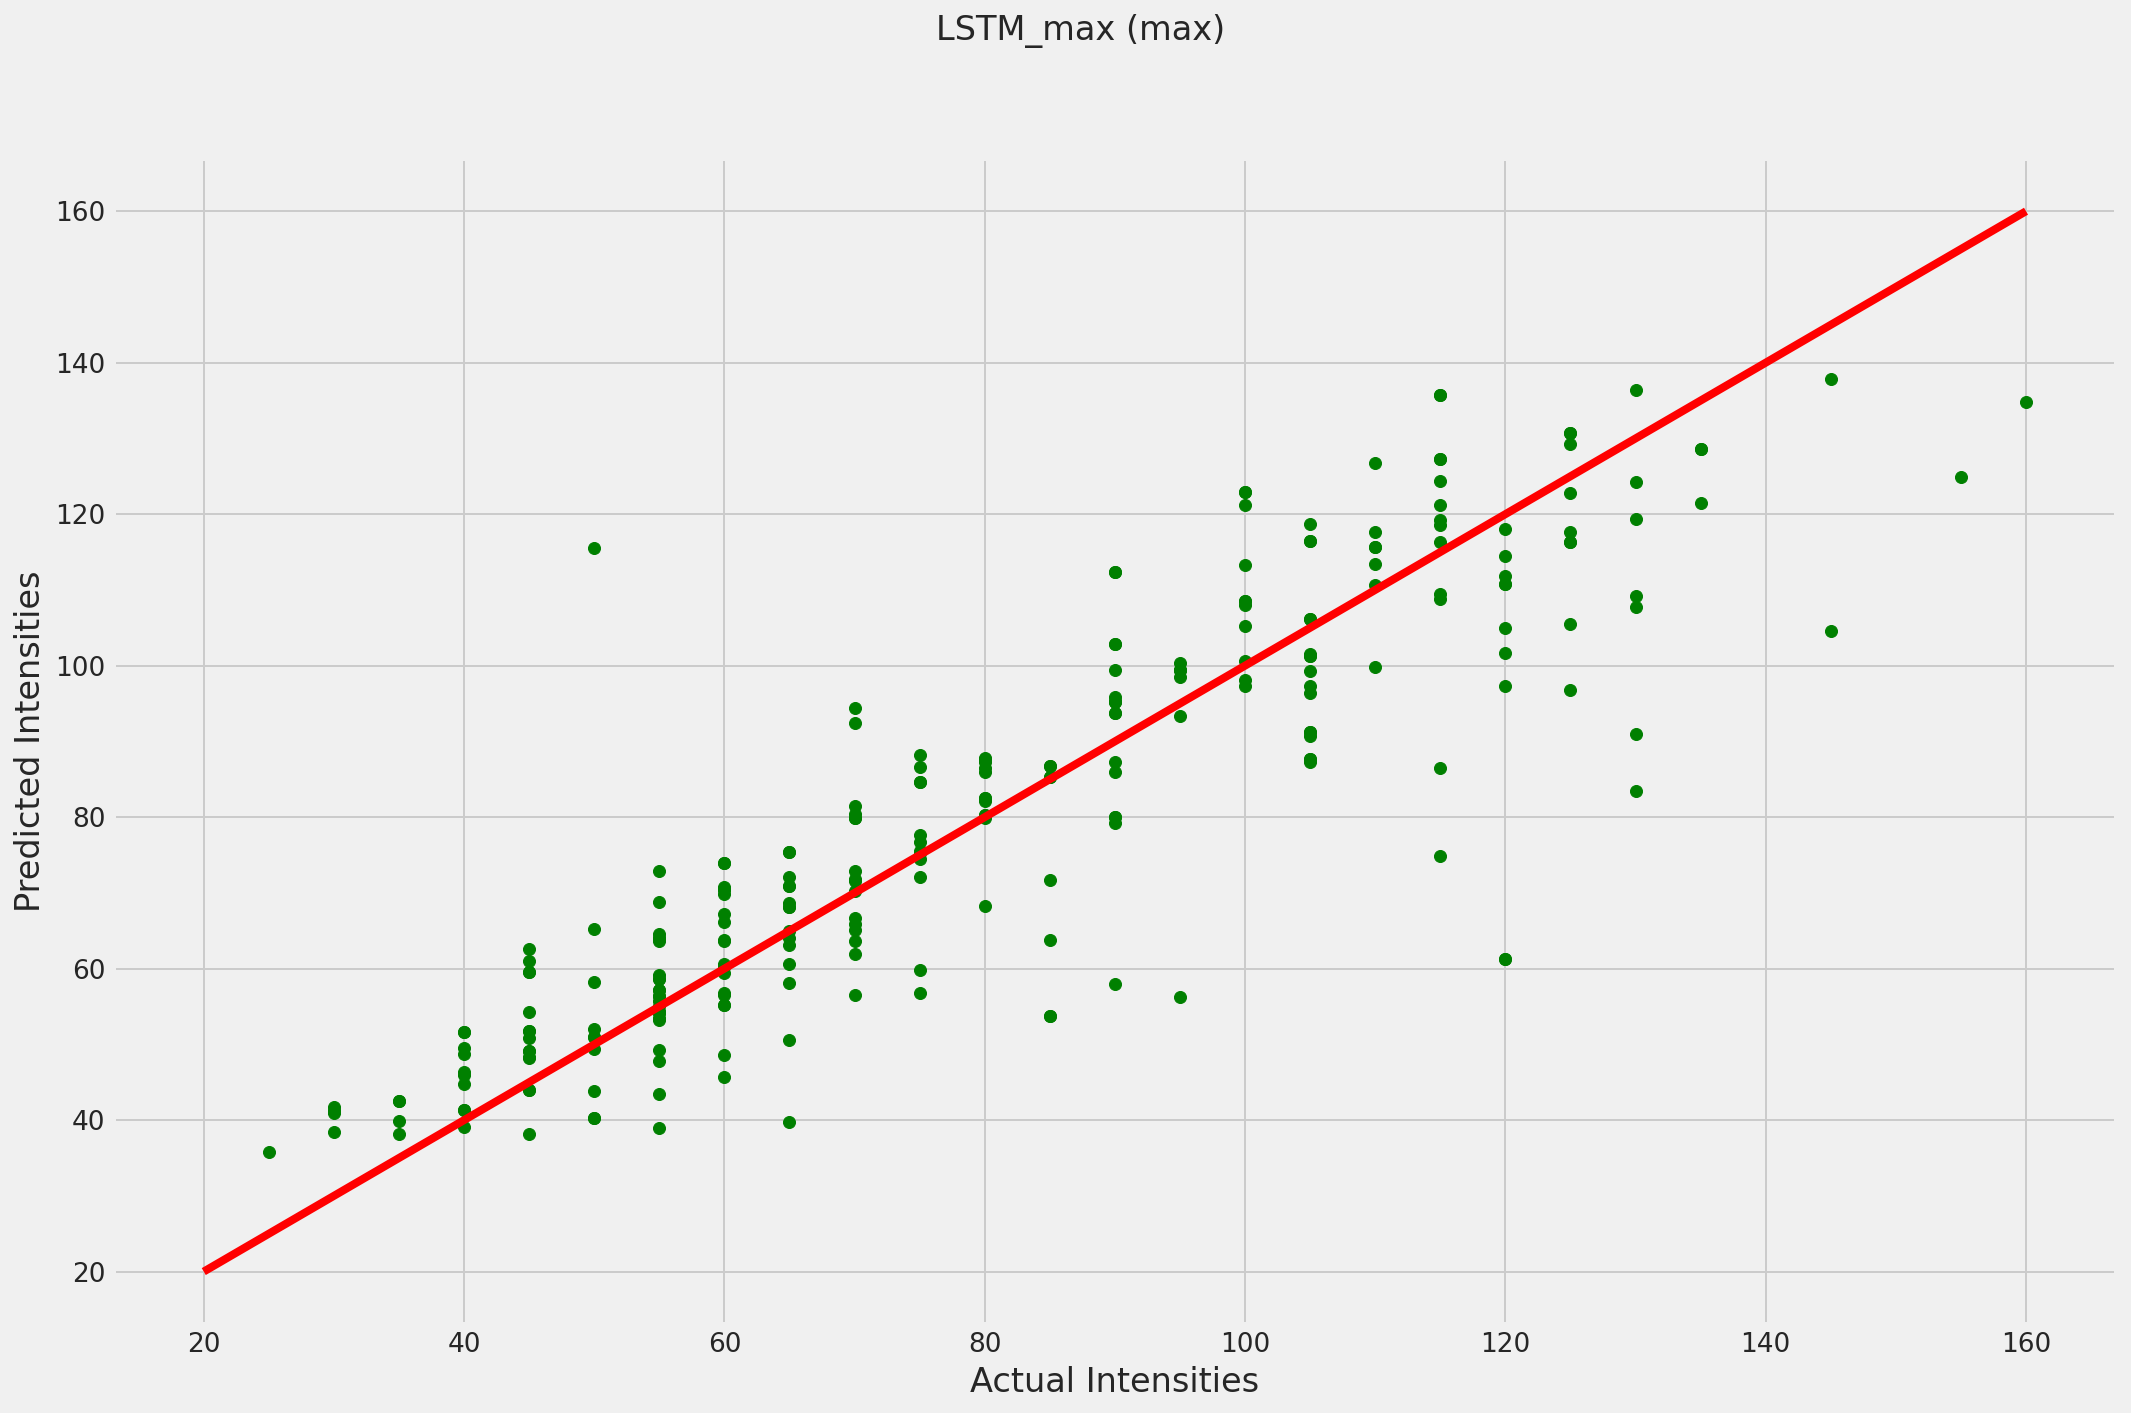

In [ ]:
num_epochs = 25
l_model = final_model_train(num_epochs, mode = "max", approach = "LSTM_max", model_name ="LSTM_max", X_train=X_train_full_max, y_train= y_train_full_max, plot=True)

In [1]:
from captum.attr import Saliency
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

ModuleNotFoundError: ignored

In [ ]:
X_test_max.shape
X_test_r = X_test_max.reshape(-1,16)
X_test_r.shape

torch.Size([256, 16])

In [ ]:
ig = IntegratedGradients(l_model)
# X_test_max.requires_grad_()
attr, delta = ig.attribute(X_test_r)
attr = attr.detach().numpy()

RuntimeError: ignored

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
import time
import progressbar
from fastprogress import master_bar, progress_bar
from torch.autograd import Variable

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
trainX = X_train_max
trainY = y_train_max
testX = X_test_max
testY = y_test_max
trainX.shape, trainY.shape

(torch.Size([2880, 16, 1]), torch.Size([2880, 1]))

In [ ]:
num_epochs = 150
learning_rate = 1e-3
input_size = 1
hidden_size = 128
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, loss: 0.24033 valid loss:  0.24763 
Epoch: 50, loss: 0.05766 valid loss:  0.04111 
Epoch: 100, loss: 0.05570 valid loss:  0.03032 


In [ ]:
# lstm.train()
# ig = IntegratedGradients(lstm)
# testX.requires_grad_()
# ig_attr_test = ig.attribute(testX)
# ig_attr_test = ig_attr_test.cpu().detach().numpy()

In [ ]:
lstm.train()
ig = IntegratedGradients(lstm)
dl = DeepLift(lstm)
gs = GradientShap(lstm)

ig_attr_test = ig.attribute(testX, n_steps=50) 
dl_attr_test = dl.attribute(testX)
gs_attr_test = gs.attribute(testX, trainX)

/usr/local/lib/python3.8/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
x_axis_data = np.arange(trainX.shape[1])
ig_attr_test_sum = ig_attr_test.cpu().detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
 
dl_attr_test_sum = dl_attr_test.cpu().detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.cpu().detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

Text(0.5, 1.0, 'Integrated Gradient')

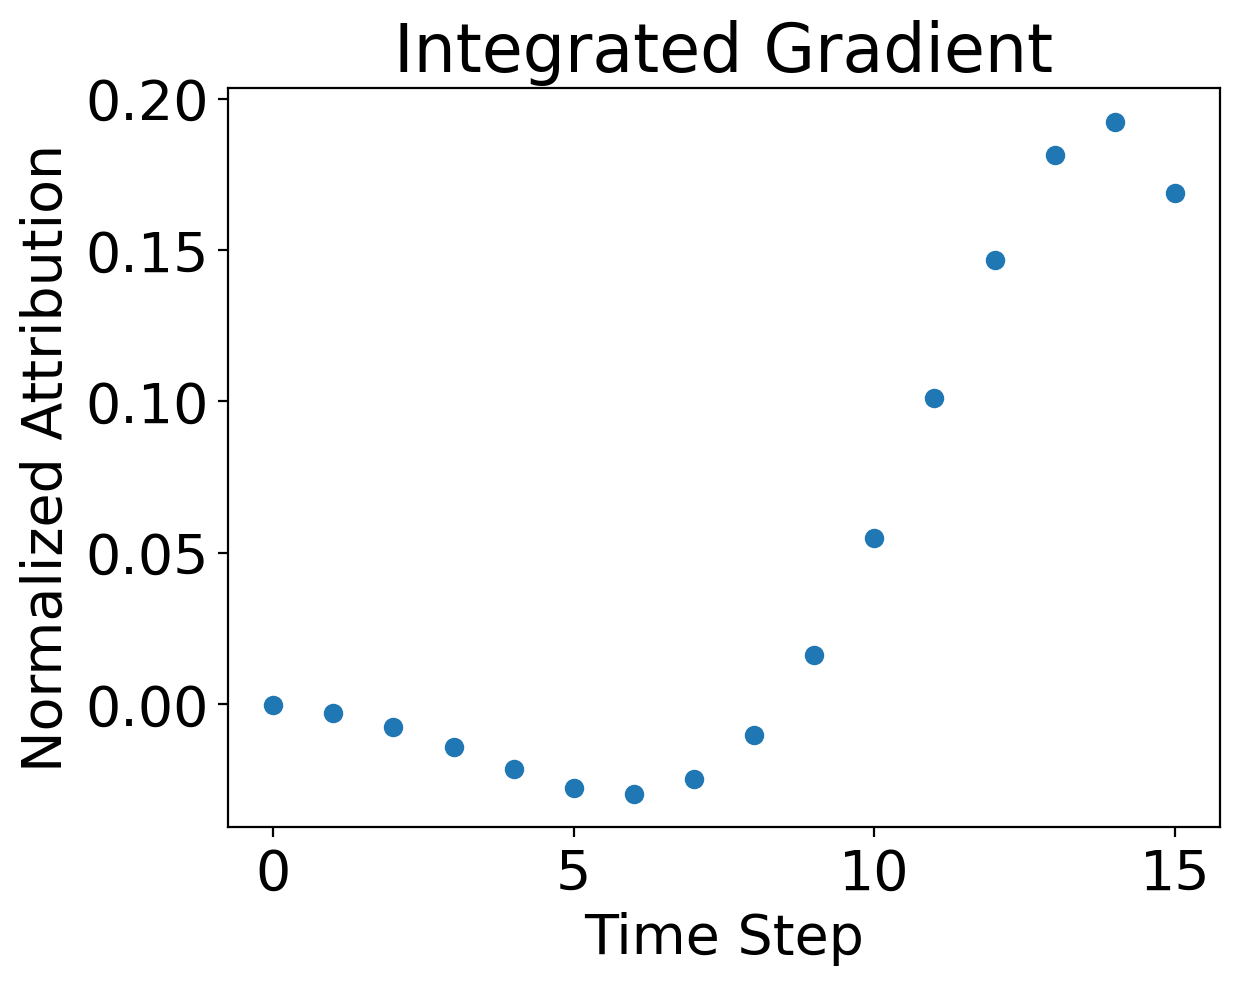

In [ ]:
rcParams['figure.figsize'] = 24, 10
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.scatter(x_axis_data, ig_attr_test_norm_sum)
plt.xlabel('Time Step')
plt.ylabel('Normalized Attribution')
plt.title('Integrated Gradient')

Text(0.5, 1.0, 'DeepLift')

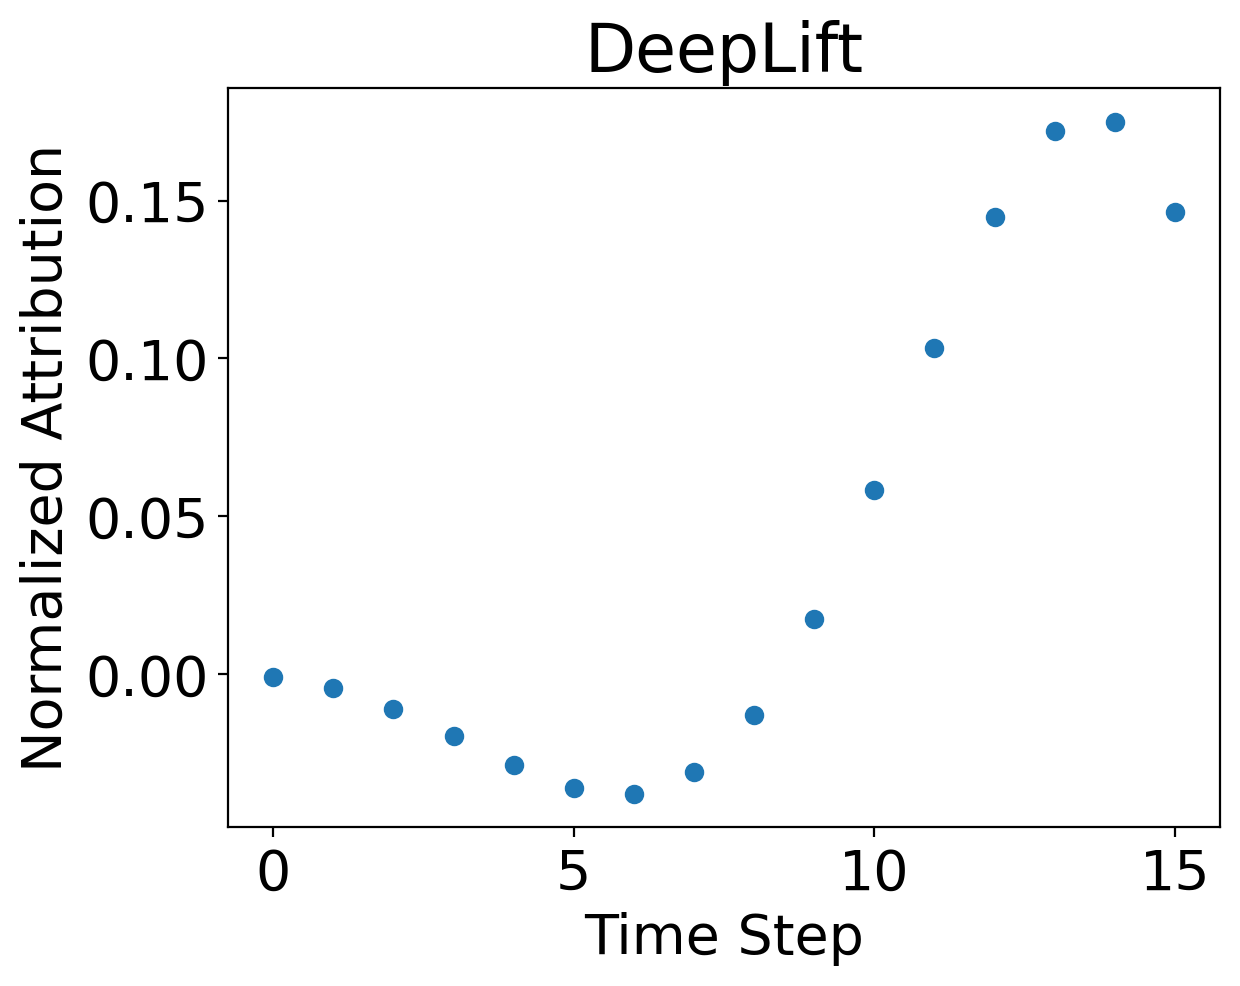

In [ ]:
rcParams['figure.figsize'] = 24, 10
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.scatter(x_axis_data, dl_attr_test_norm_sum)
plt.xlabel('Time Step')
plt.ylabel('Normalized Attribution')
plt.title('DeepLift')

Text(0.5, 1.0, 'GradientSHAP')

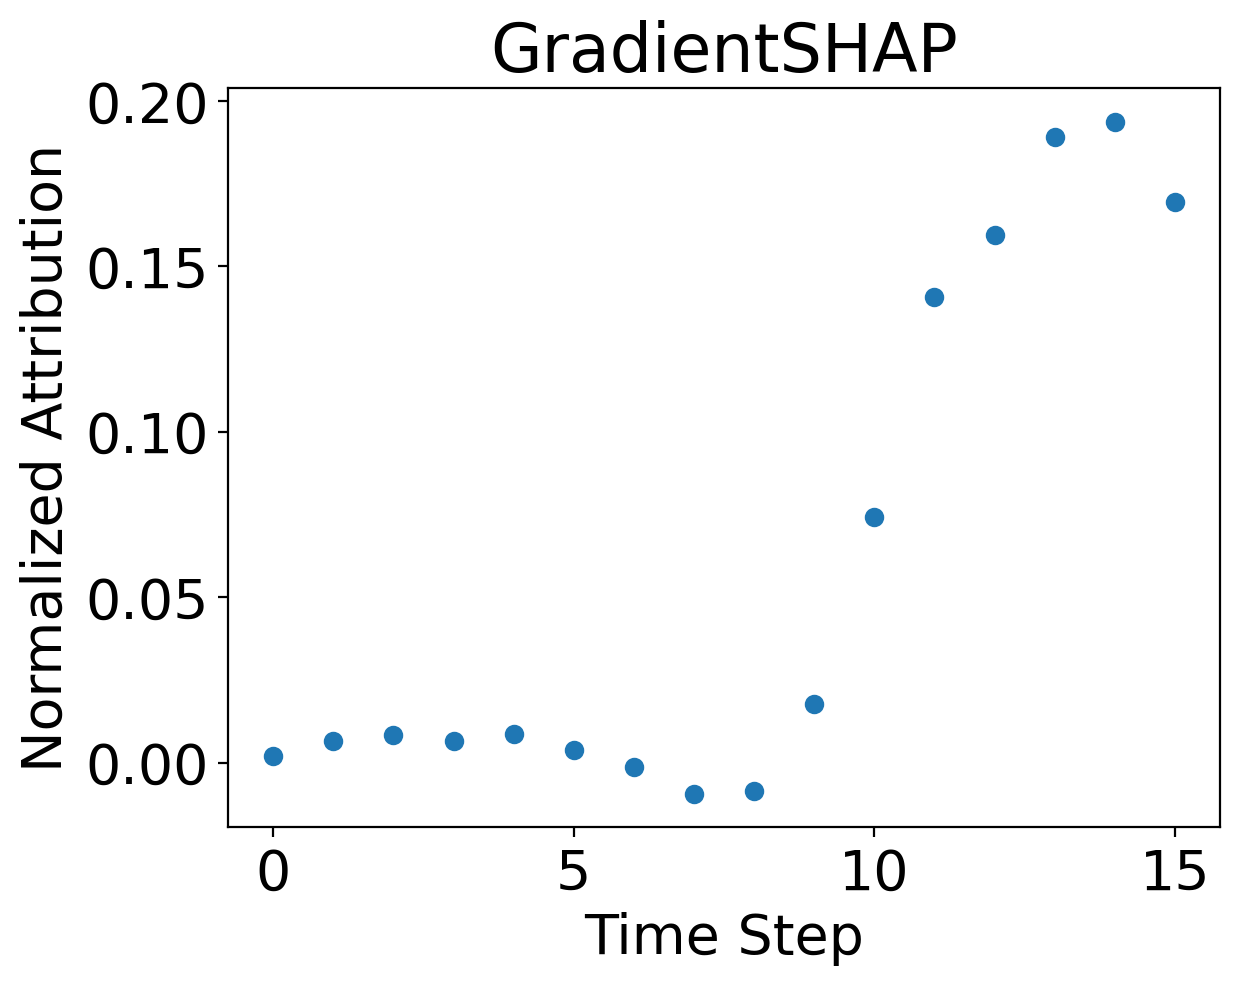

In [ ]:
rcParams['figure.figsize'] = 24, 10
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.scatter(x_axis_data, gs_attr_test_norm_sum)
plt.xlabel('Time Step')
plt.ylabel('Normalized Attribution')
plt.title('GradientSHAP')

In [ ]:
from captum.attr import (
    DeepLift,
    visualization as viz,
)

In [ ]:
train_pred = lstm(trainX.to(device))
train_pred = train_pred.cpu().data.numpy() 
train_pred = scaler.inverse_transform(train_pred)
train_pred

array([[79.72643],
       [79.72643],
       [79.72643],
       ...,
       [76.10971],
       [76.13026],
       [93.02276]], dtype=float32)

In [ ]:
a = trainX.to(device)
a = a.cpu().data.numpy() 
a = scaler.inverse_transform(a)
a

ValueError: ignored

In [ ]:
train_predictions_max, train_actuals_max = inverse_scaler(train_predictions_max, train_actuals_max)

In [ ]:
attrs = ig_attr_test

In [ ]:
dl = DeepLift(lstm, multiply_by_inputs=False)

_x = torch.tensor(testX[0])
_x = torch.unsqueeze(_x, axis=0)
 
attrs = dl.attribute(_x, target=0)

# Remove batch dimension for plotting
attrs = torch.squeeze(attrs, dim=0)

# attrs = torch.squeeze(ig.attribute(testX, n_steps=50) , dim=0)
_x = torch.squeeze(_x, dim=0).cpu().detach().numpy()

attrs = attrs.cpu().detach().numpy()
#_x = _x.numpy()
print(attrs.shape, _x.shape)


viz.visualize_timeseries_attr(
    attrs,
    _x,
    method="overlay_individual",
    channel_labels=["Ch1"],
    channels_last=True,
    show_colorbar=False,
    fig_size=(14, 6),
    color="black"
)

# viz.visualize_timeseries_attr(
#     attrs,
#     _x,
#     x_values=np.linspace(0, 100, 250),
#     method="overlay_combined",
#     channel_labels=["Ch1"],
#     channels_last=True,
#     show_colorbar=True,
#     alpha_overlay=0.5,
#     fig_size=(10, 5),
# )

viz.visualize_timeseries_attr(
    attrs,
    _x,
    method="colored_graph",
    channel_labels=["Ch1"],
    channels_last=True,
    show_colorbar=False,
    cmap="RdYlBu_r",
    fig_size=(10, 5),
    linewidth=3,
)

(16, 1) (16, 1)


<ipython-input-157-be06ded10c65>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[0])
/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


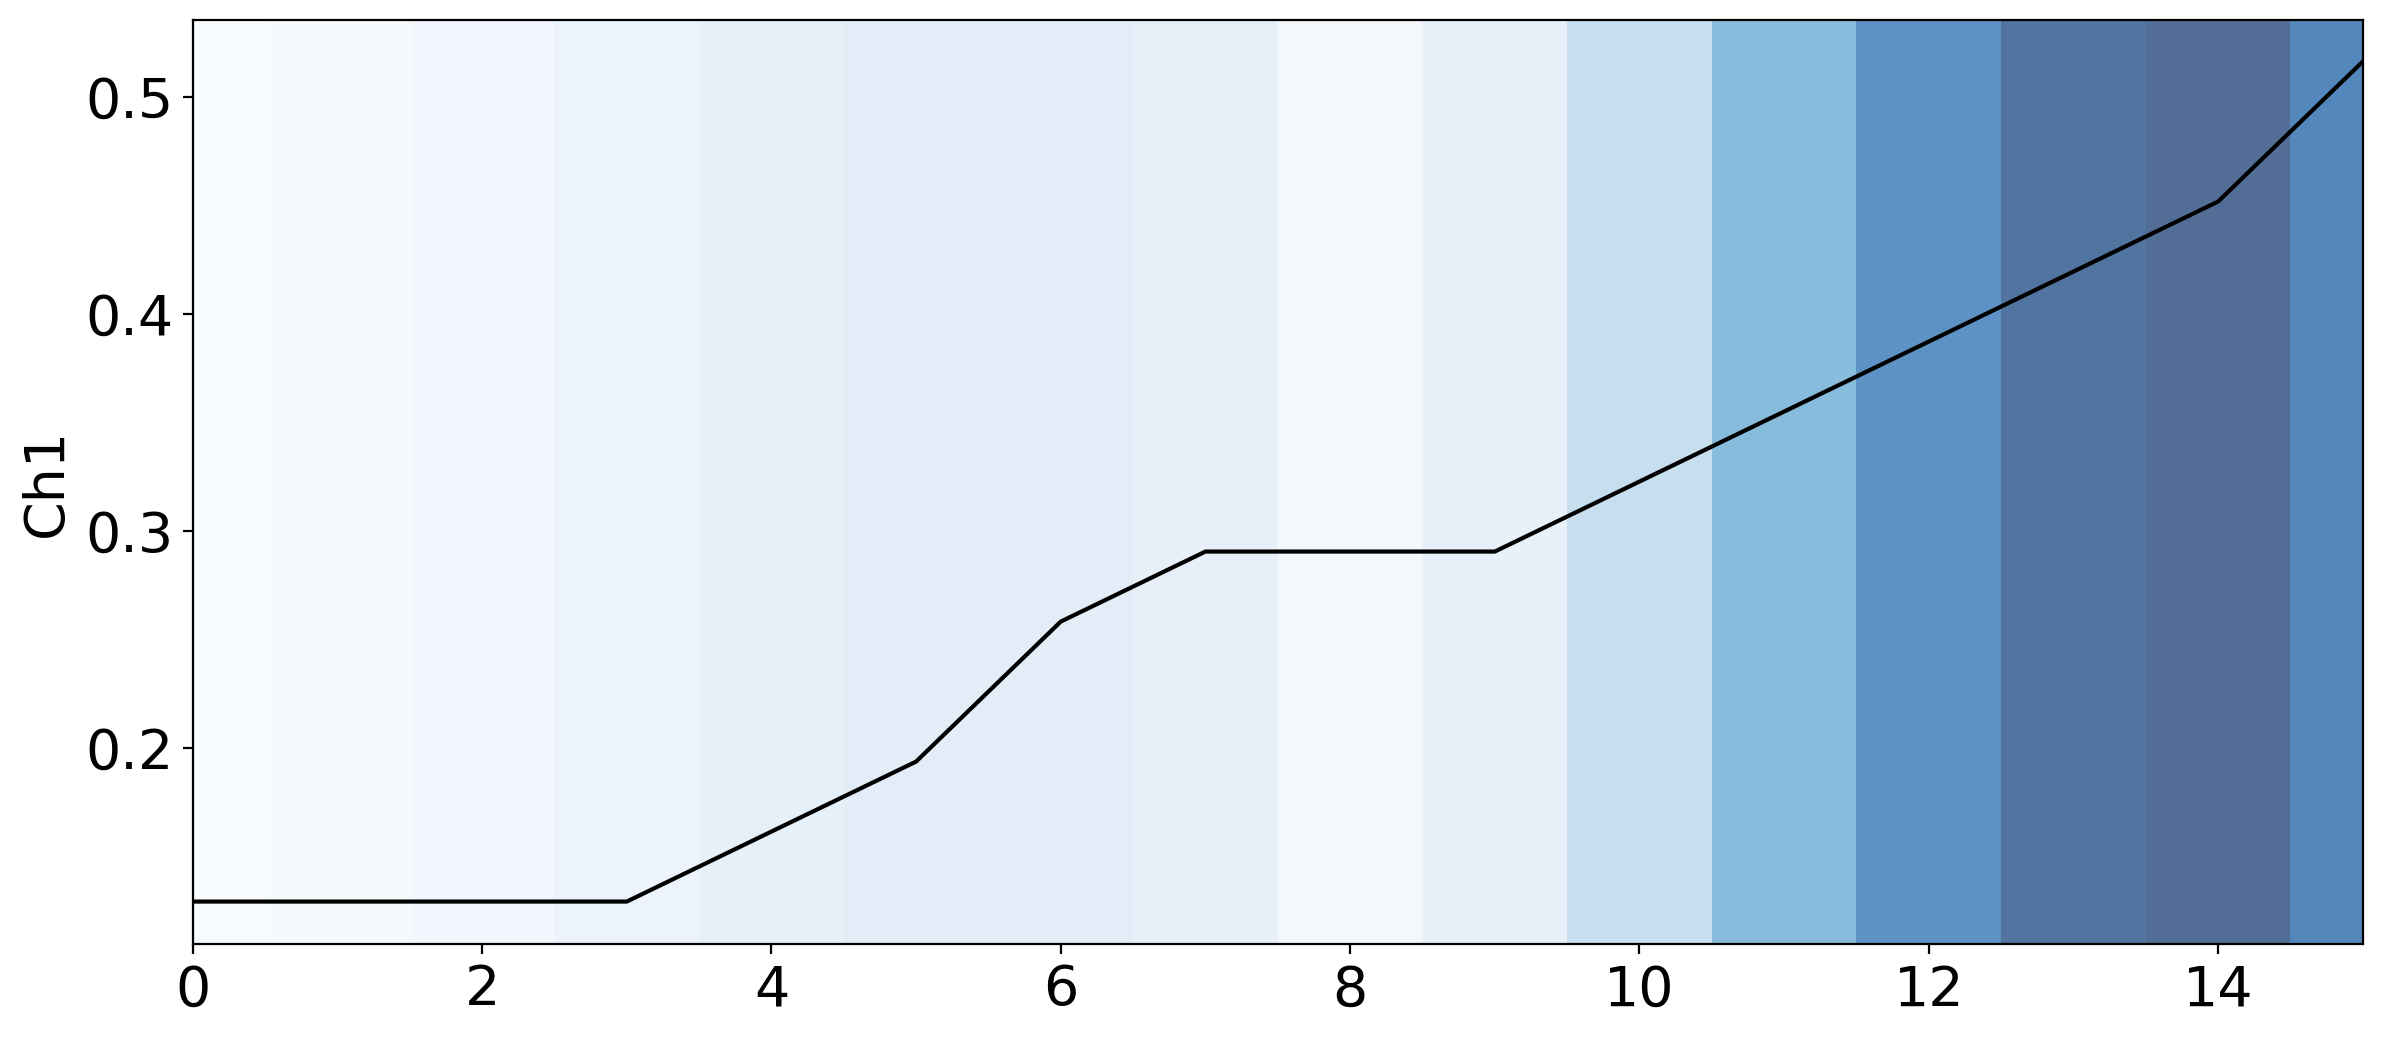

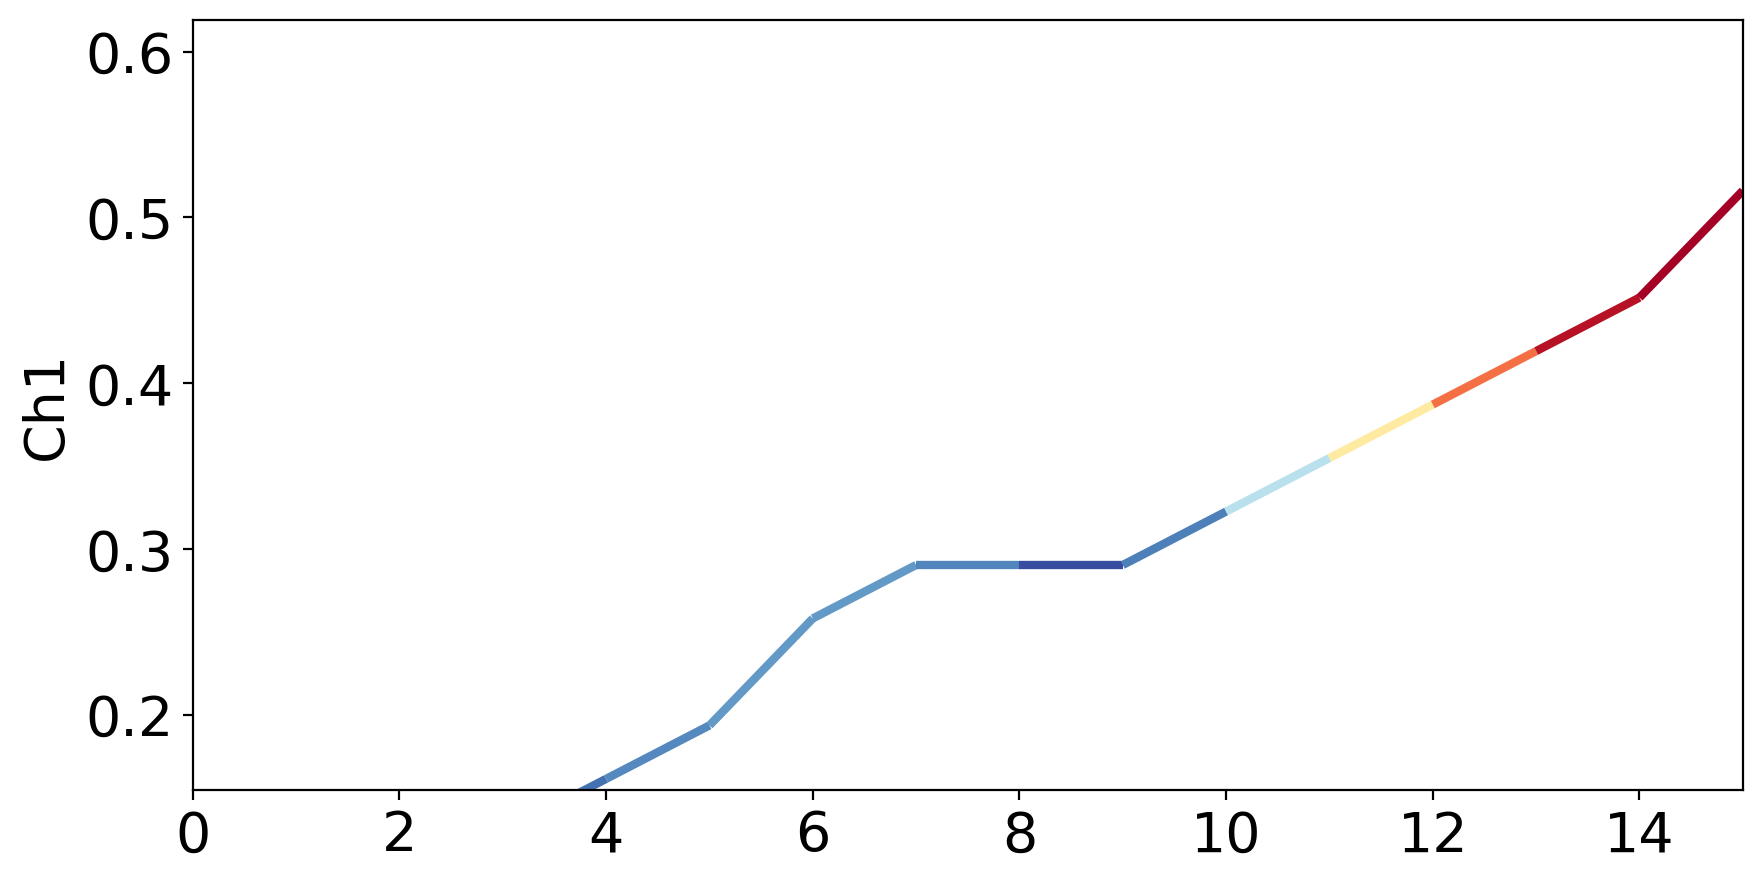

(<Figure size 1000x500 with 1 Axes>,
 array([<AxesSubplot:ylabel='Ch1'>], dtype=object))

In [ ]:
def attribution(datapoint=0): 
  dl = DeepLift(lstm, multiply_by_inputs=False)

  _x = torch.tensor(testX[datapoint])
  _x = torch.unsqueeze(_x, axis=0)
  
  attrs = dl.attribute(_x, target=0)

  # Remove batch dimension for plotting
  attrs = torch.squeeze(attrs, dim=0)

  # attrs = torch.squeeze(ig.attribute(testX, n_steps=50) , dim=0)
  _x = torch.squeeze(_x, dim=0).cpu().detach().numpy()

  attrs = attrs.cpu().detach().numpy()
  #_x = _x.numpy()
  # print(attrs.shape, _x.shape)


  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="overlay_individual",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      fig_size=(14, 6),
      color="black"
  )

  # viz.visualize_timeseries_attr(
  #     attrs,
  #     _x,
  #     x_values=np.linspace(0, 100, 250),
  #     method="overlay_combined",
  #     channel_labels=["Ch1"],
  #     channels_last=True,
  #     show_colorbar=True,
  #     alpha_overlay=0.5,
  #     fig_size=(10, 5),
  # )

  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="colored_graph",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      cmap="RdYlBu_r",
      fig_size=(10, 5),
      linewidth=3,
  )

<ipython-input-169-75ef70d804f4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])


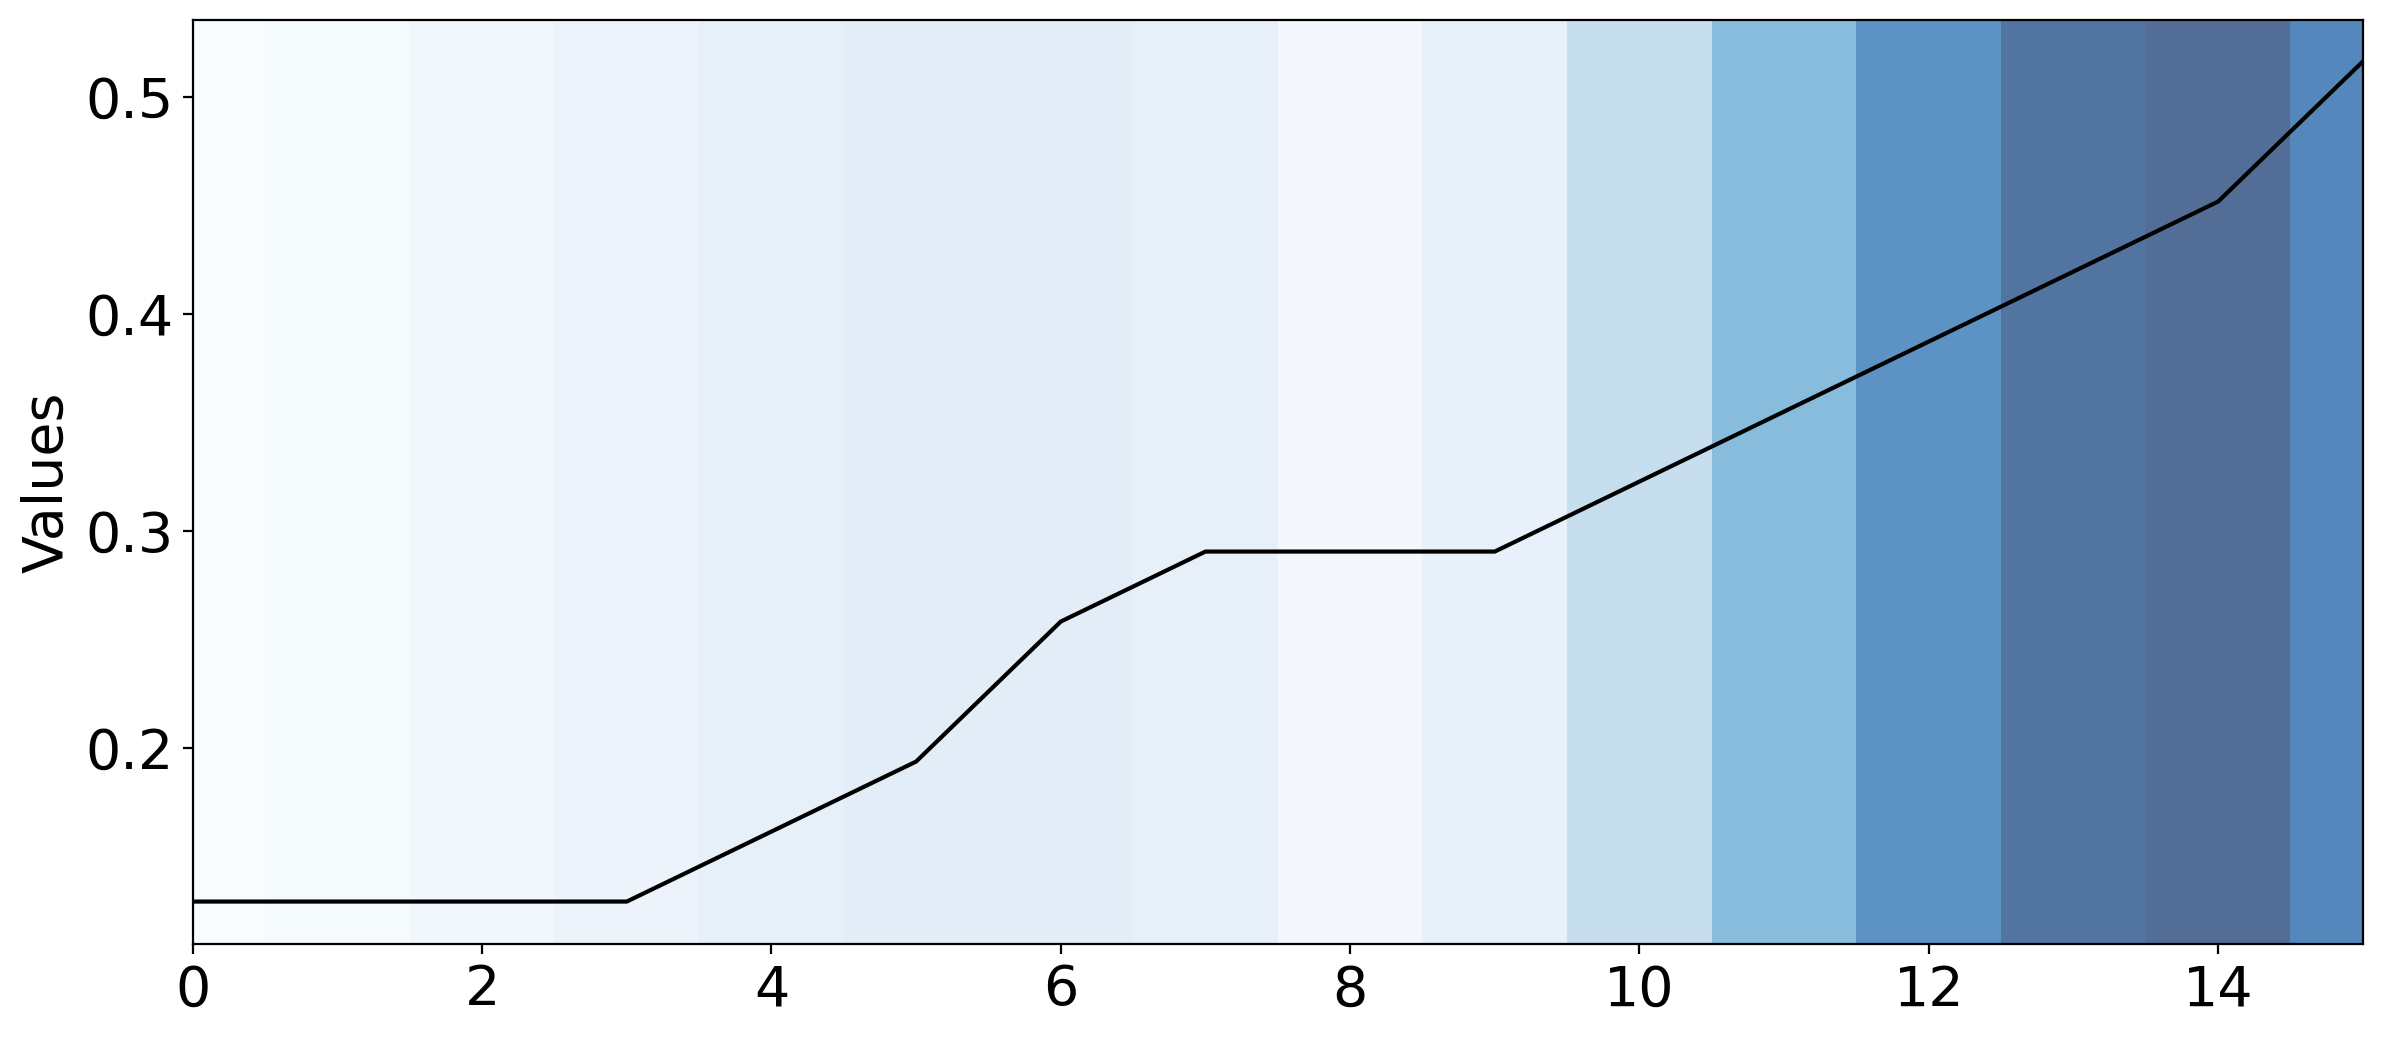

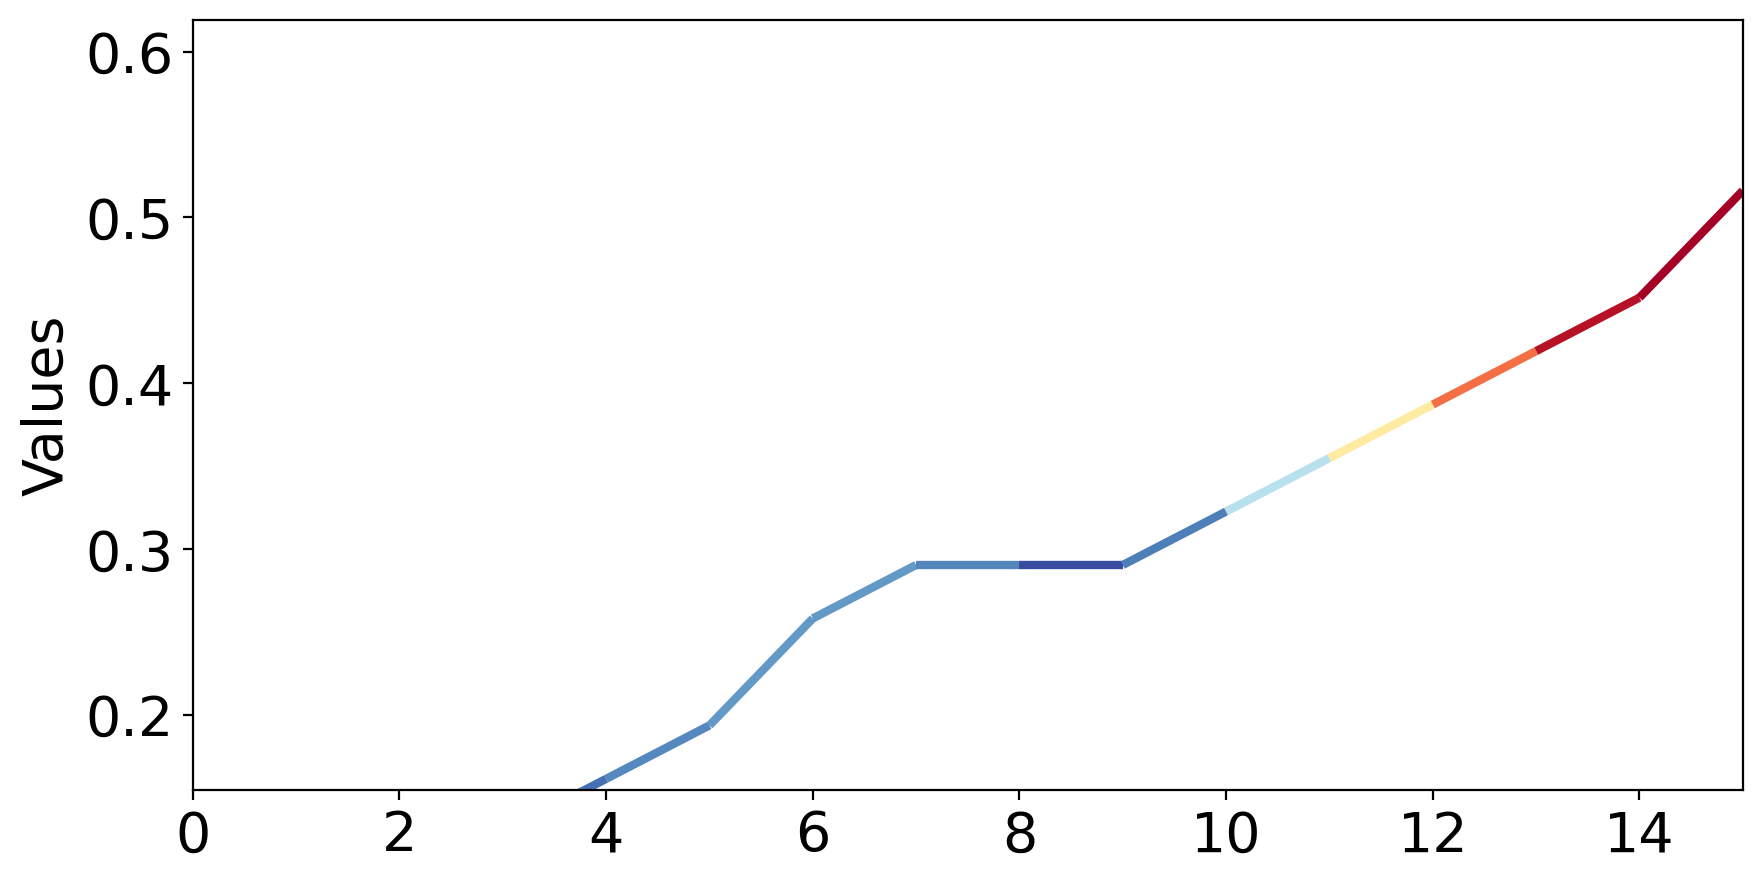

In [ ]:
attribution(0)

<ipython-input-169-75ef70d804f4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])


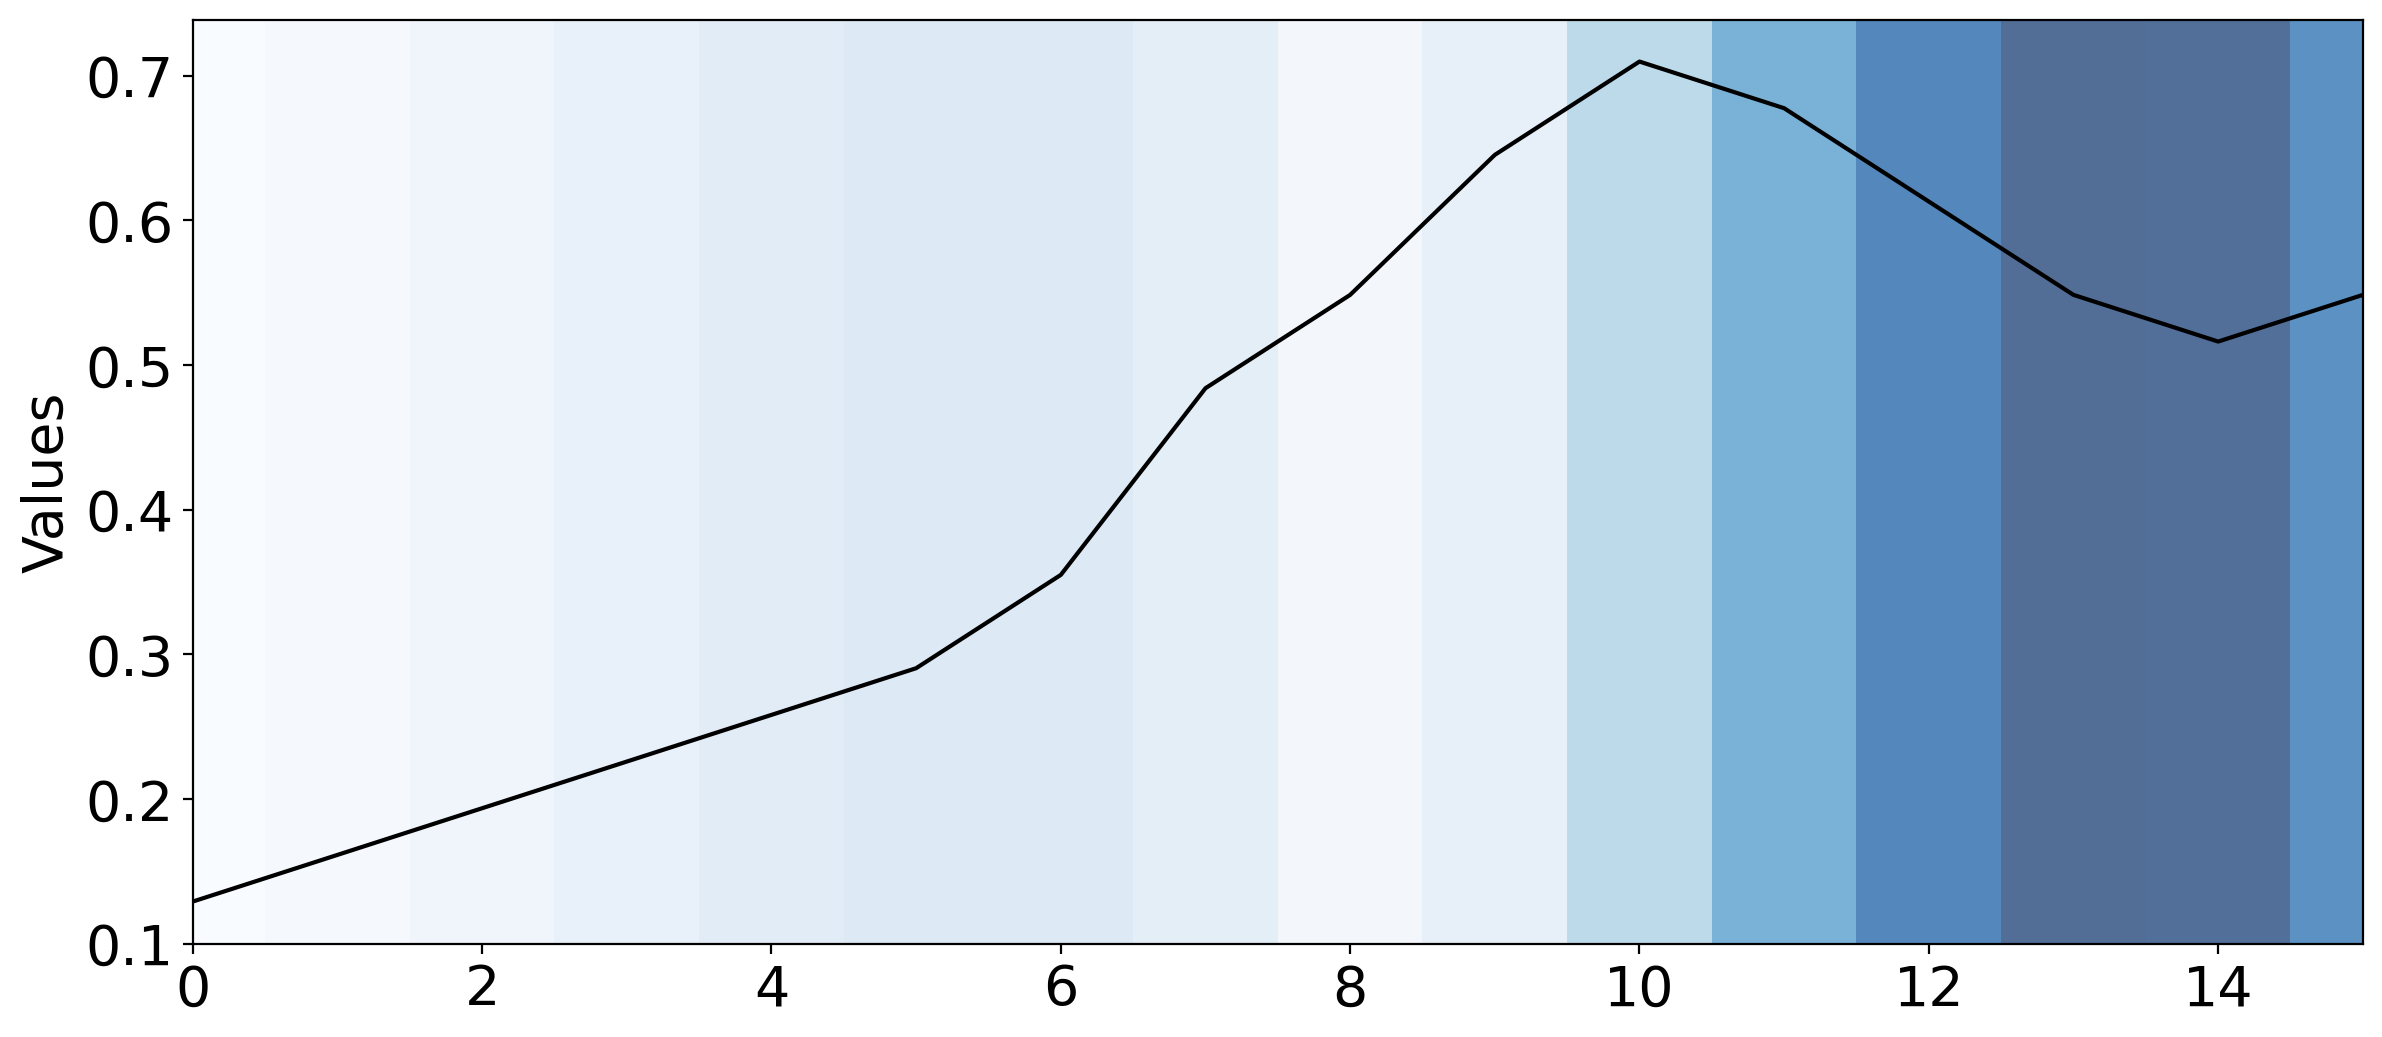

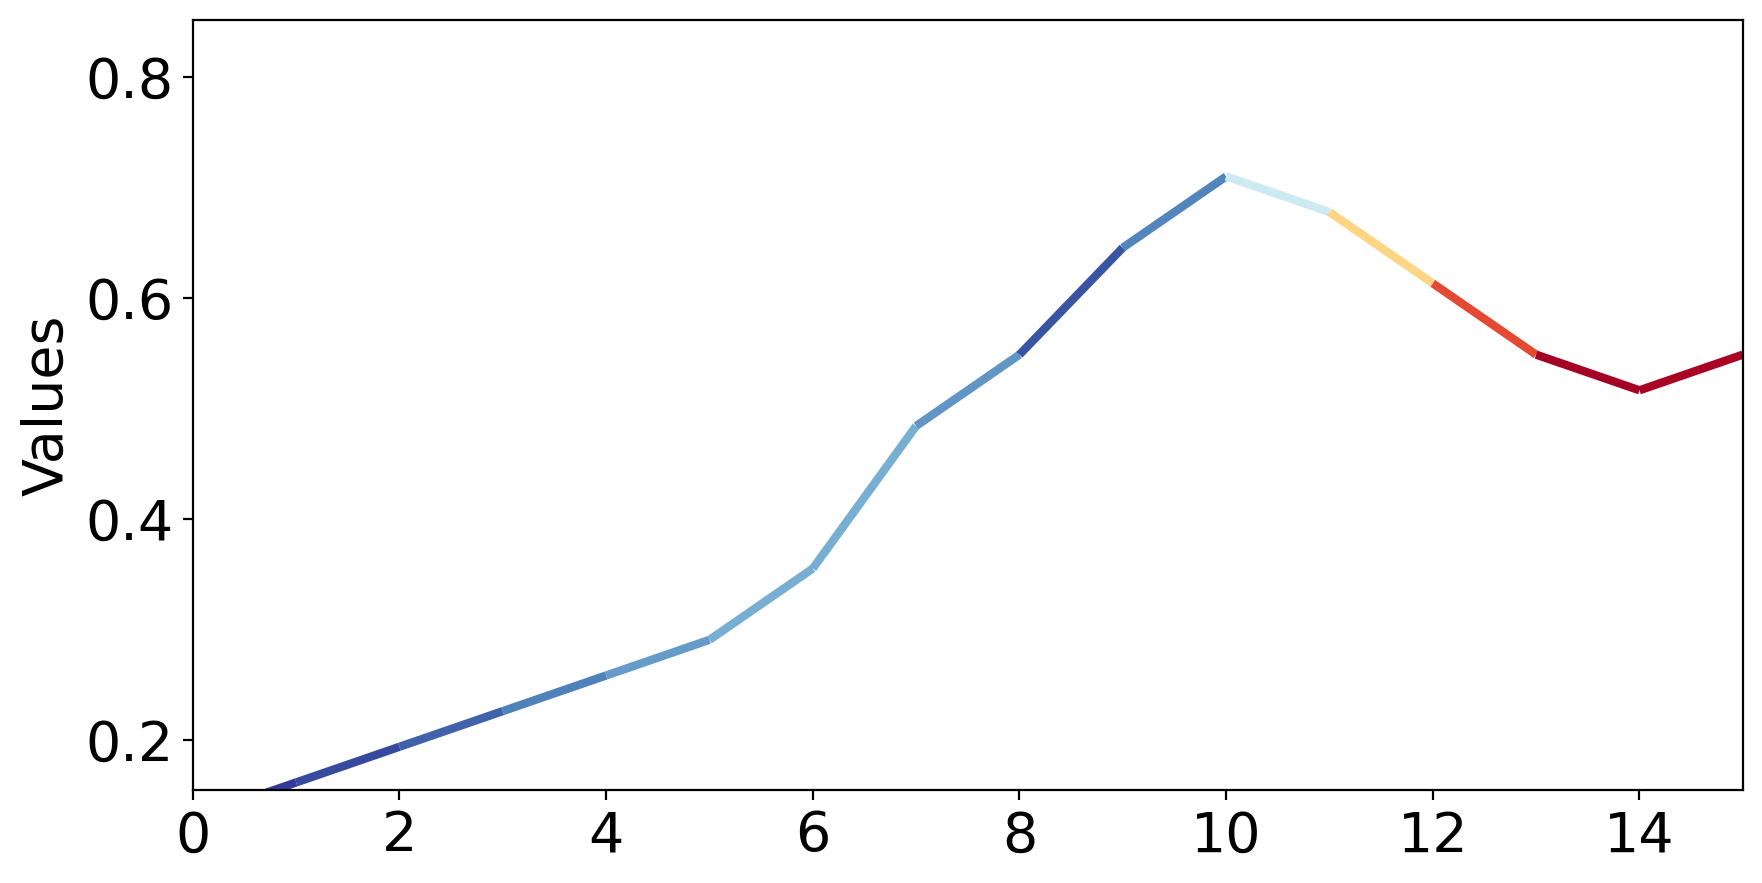

In [ ]:
attribution(2)

In [ ]:
def attribution(datapoint=0): 
  dl = GradientShap(lstm)
  baselines = torch.randn(1, 16, 1).to(device)
  _x = torch.tensor(testX[datapoint])
  _x = torch.unsqueeze(_x, axis=0)
  # print(baselines.shape, _x.shape)
  attrs = dl.attribute(_x, baselines)

  # Remove batch dimension for plotting
  attrs = torch.squeeze(attrs, dim=0)

  # attrs = torch.squeeze(ig.attribute(testX, n_steps=50) , dim=0)
  _x = torch.squeeze(_x, dim=0).cpu().detach().numpy()

  attrs = attrs.cpu().detach().numpy()
  #_x = _x.numpy()
  


  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="overlay_individual",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      fig_size=(14, 6),
      color="black"
  )

  # viz.visualize_timeseries_attr(
  #     attrs,
  #     _x,
  #     x_values=np.linspace(0, 100, 250),
  #     method="overlay_combined",
  #     channel_labels=["Ch1"],
  #     channels_last=True,
  #     show_colorbar=True,
  #     alpha_overlay=0.5,
  #     fig_size=(10, 5),
  # )

  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="colored_graph",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      cmap="RdYlBu_r",
      fig_size=(10, 5),
      linewidth=3,
  )

<ipython-input-187-bdff25f826a9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])


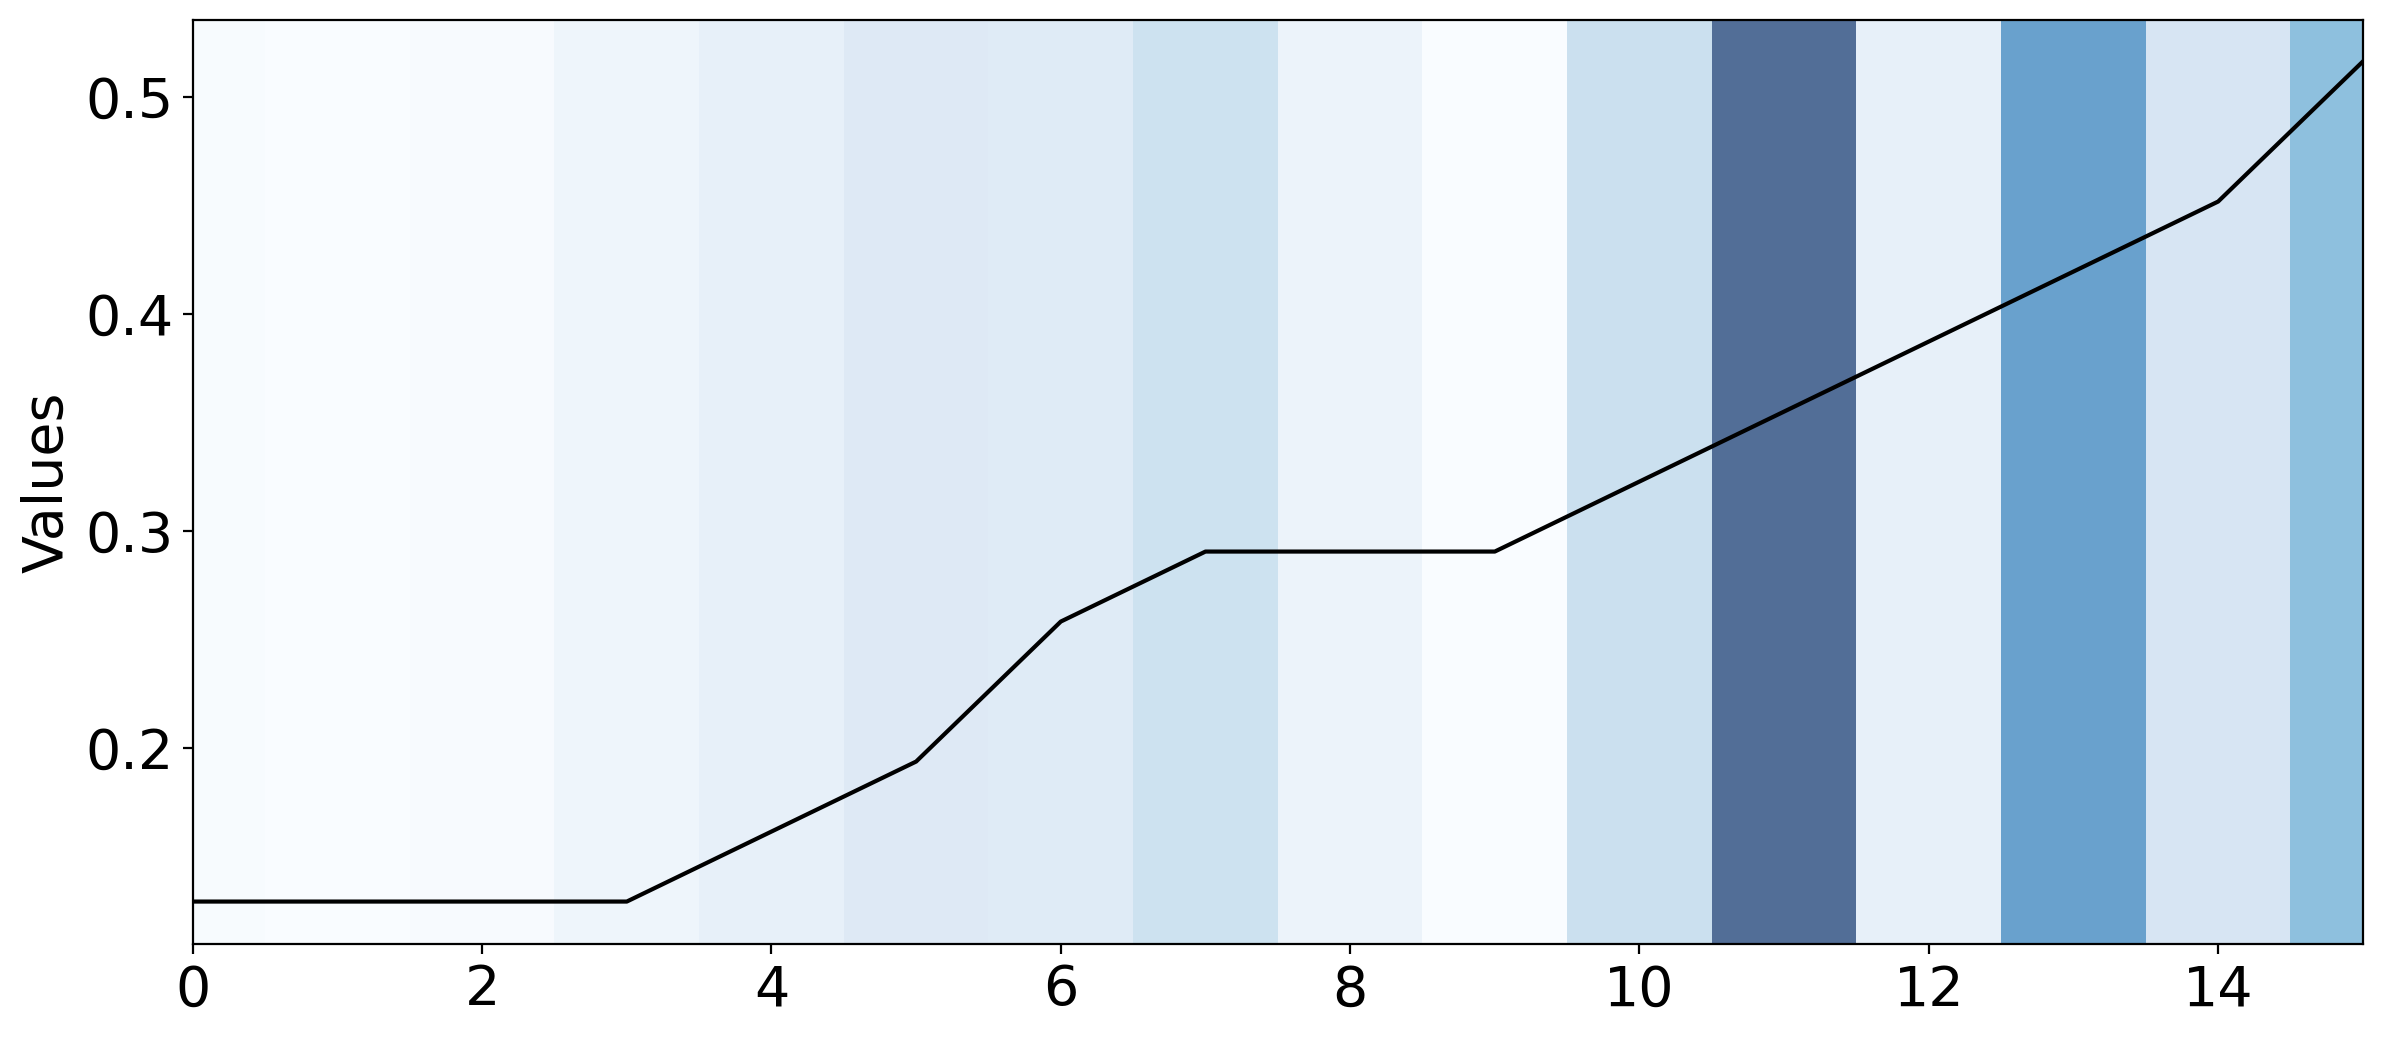

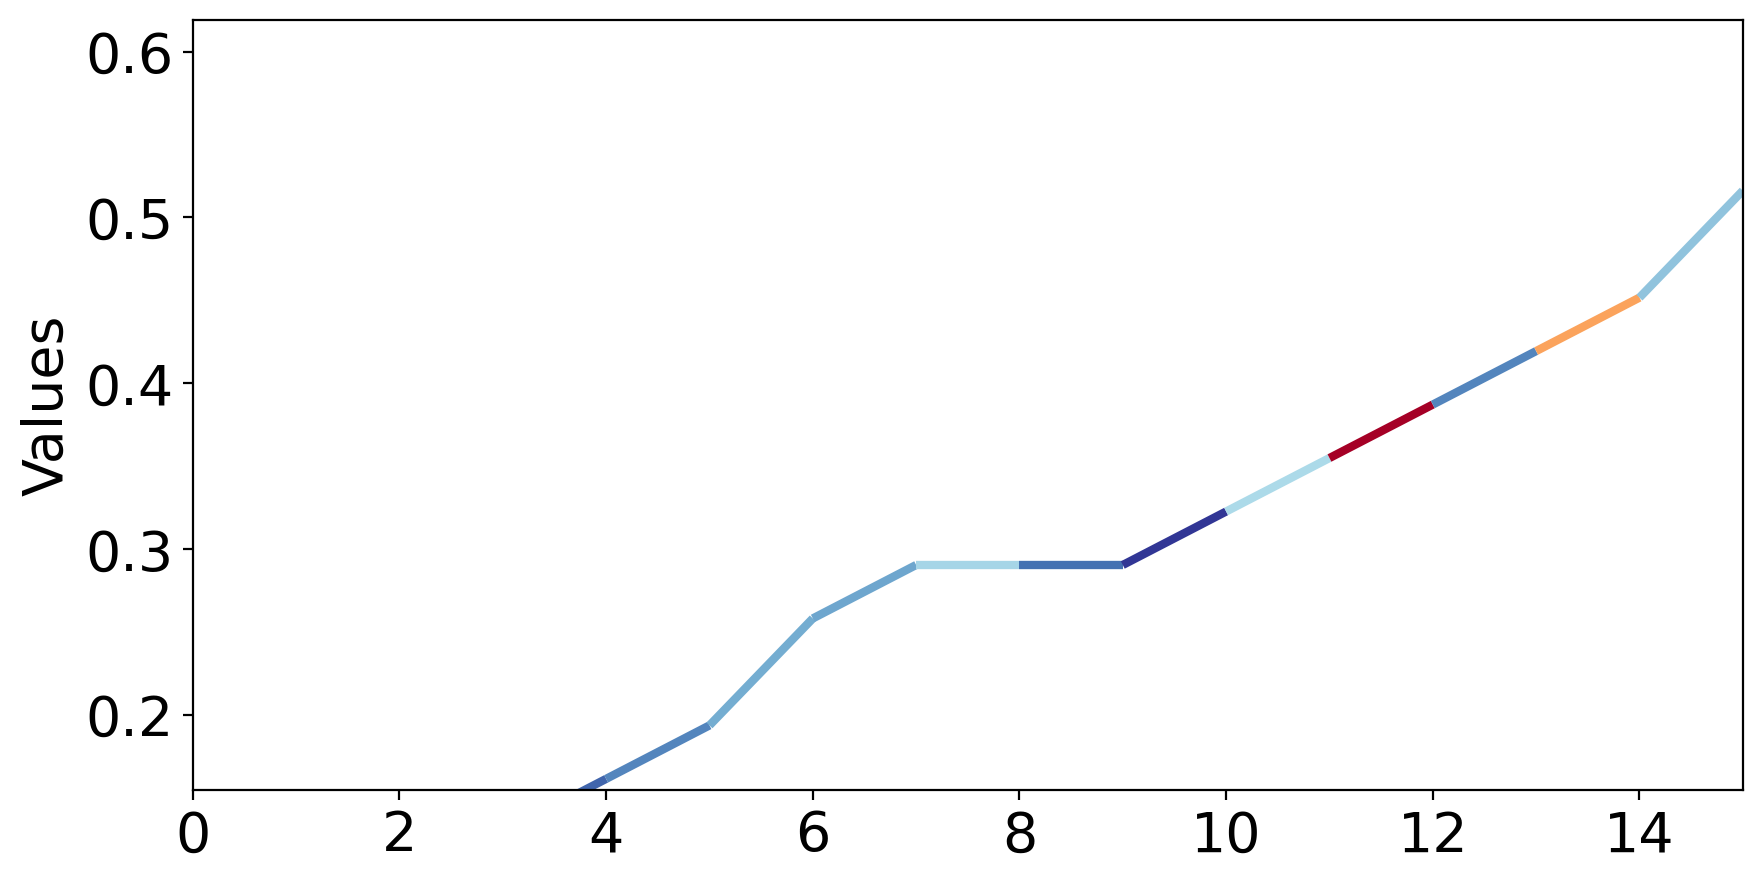

In [ ]:
attribution(0)

<ipython-input-187-bdff25f826a9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])


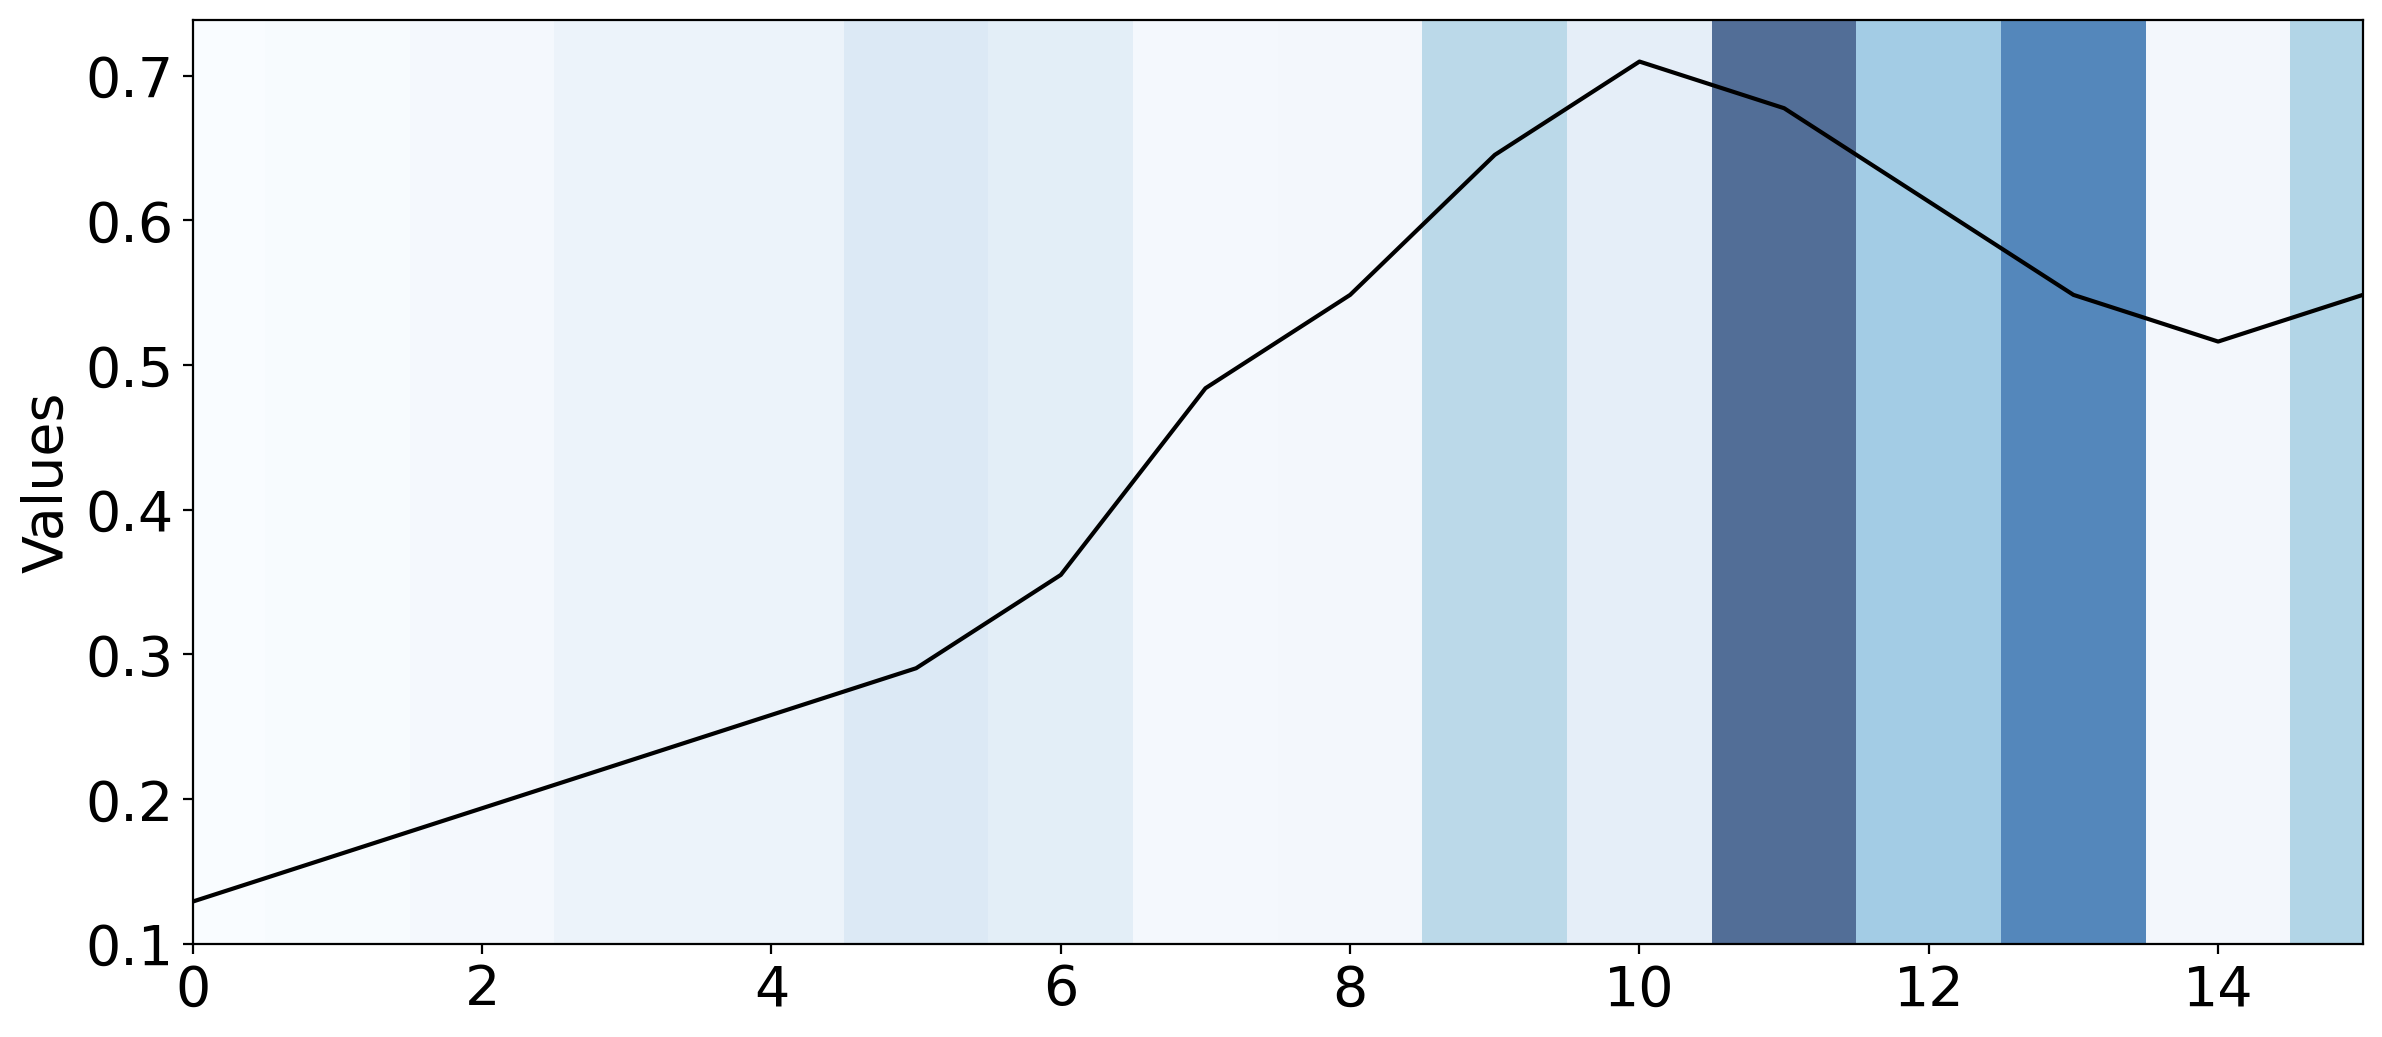

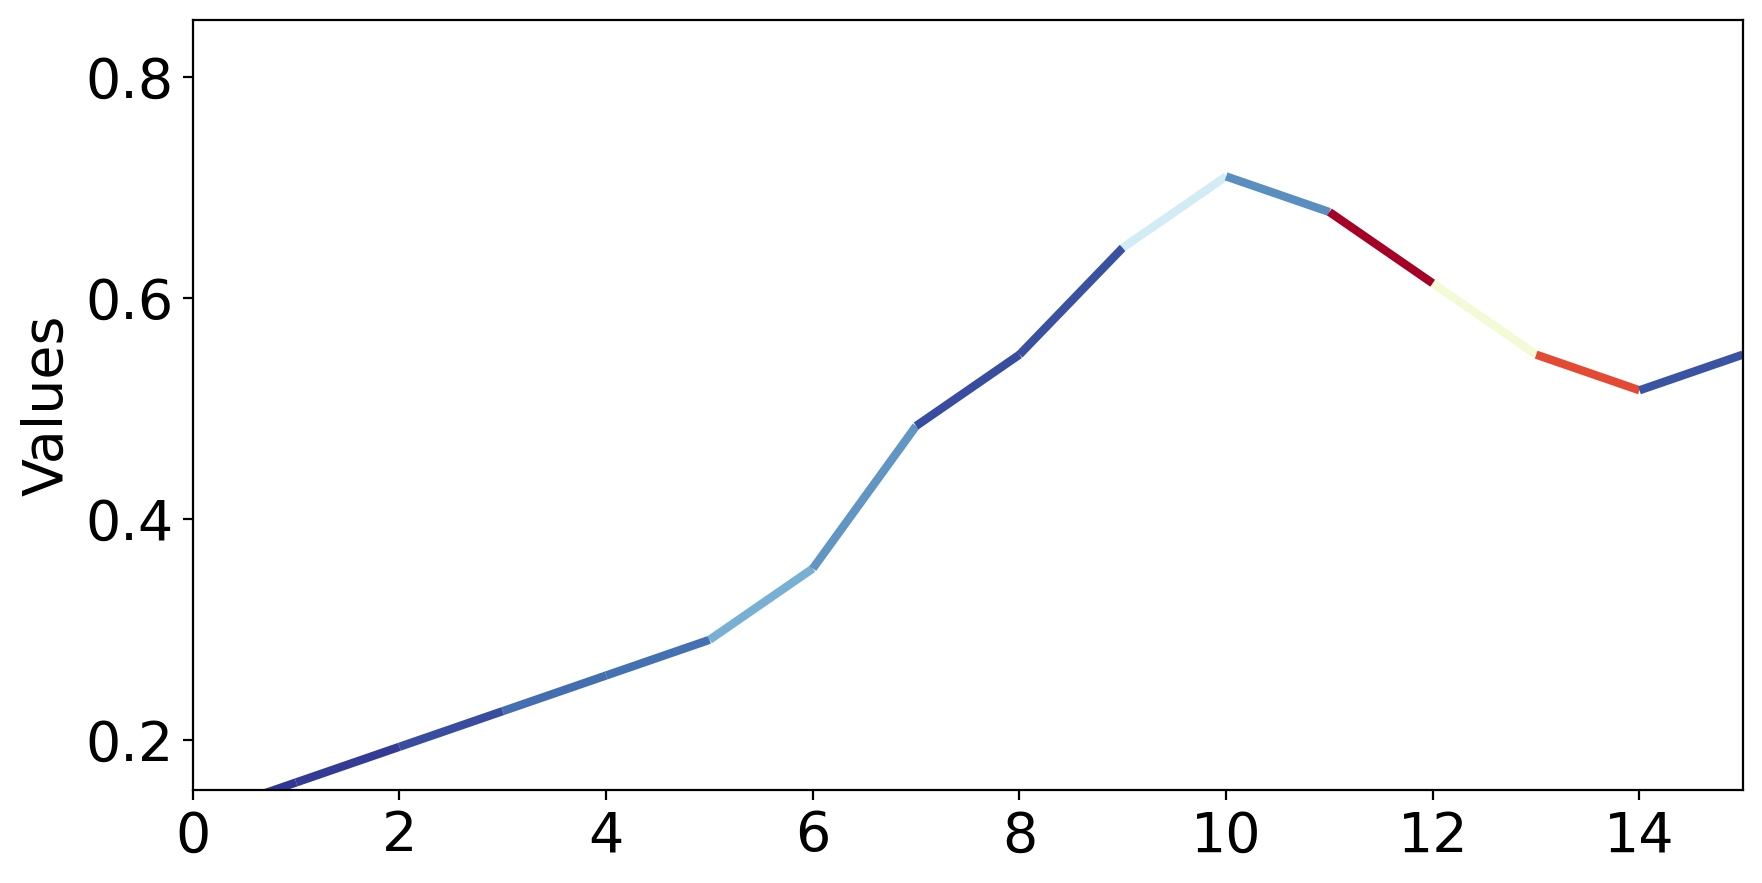

In [ ]:
attribution(2)

In [ ]:
def attribution(datapoint=0): 
  at = Saliency(lstm)
  baselines = torch.randn(1, 16, 1).to(device)
  _x = torch.tensor(testX[datapoint])
  _x = torch.unsqueeze(_x, axis=0)
  # print(baselines.shape, _x.shape)
  attrs = at.attribute(_x)
  print(attrs)
  # Remove batch dimension for plotting
  attrs = torch.squeeze(attrs, dim=0)

  # attrs = torch.squeeze(ig.attribute(testX, n_steps=50) , dim=0)
  _x = torch.squeeze(_x, dim=0).cpu().detach().numpy()

  attrs = attrs.cpu().detach().numpy()
  #_x = _x.numpy()
  


  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="overlay_individual",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      fig_size=(14, 6),
      color="black"
  )

  # viz.visualize_timeseries_attr(
  #     attrs,
  #     _x,
  #     x_values=np.linspace(0, 100, 250),
  #     method="overlay_combined",
  #     channel_labels=["Ch1"],
  #     channels_last=True,
  #     show_colorbar=True,
  #     alpha_overlay=0.5,
  #     fig_size=(10, 5),
  # )

  viz.visualize_timeseries_attr(
      attrs,
      _x,
      method="colored_graph",
      channel_labels=["Values"],
      channels_last=True,
      show_colorbar=False,
      cmap="RdYlBu_r",
      fig_size=(10, 5),
      linewidth=3,
  )

<ipython-input-196-e0a14fc56cfd>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])
/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


tensor([[[0.0007],
         [0.0046],
         [0.0108],
         [0.0187],
         [0.0267],
         [0.0325],
         [0.0330],
         [0.0254],
         [0.0070],
         [0.0231],
         [0.0639],
         [0.1111],
         [0.1567],
         [0.1896],
         [0.1967],
         [0.1689]]], device='cuda:0')


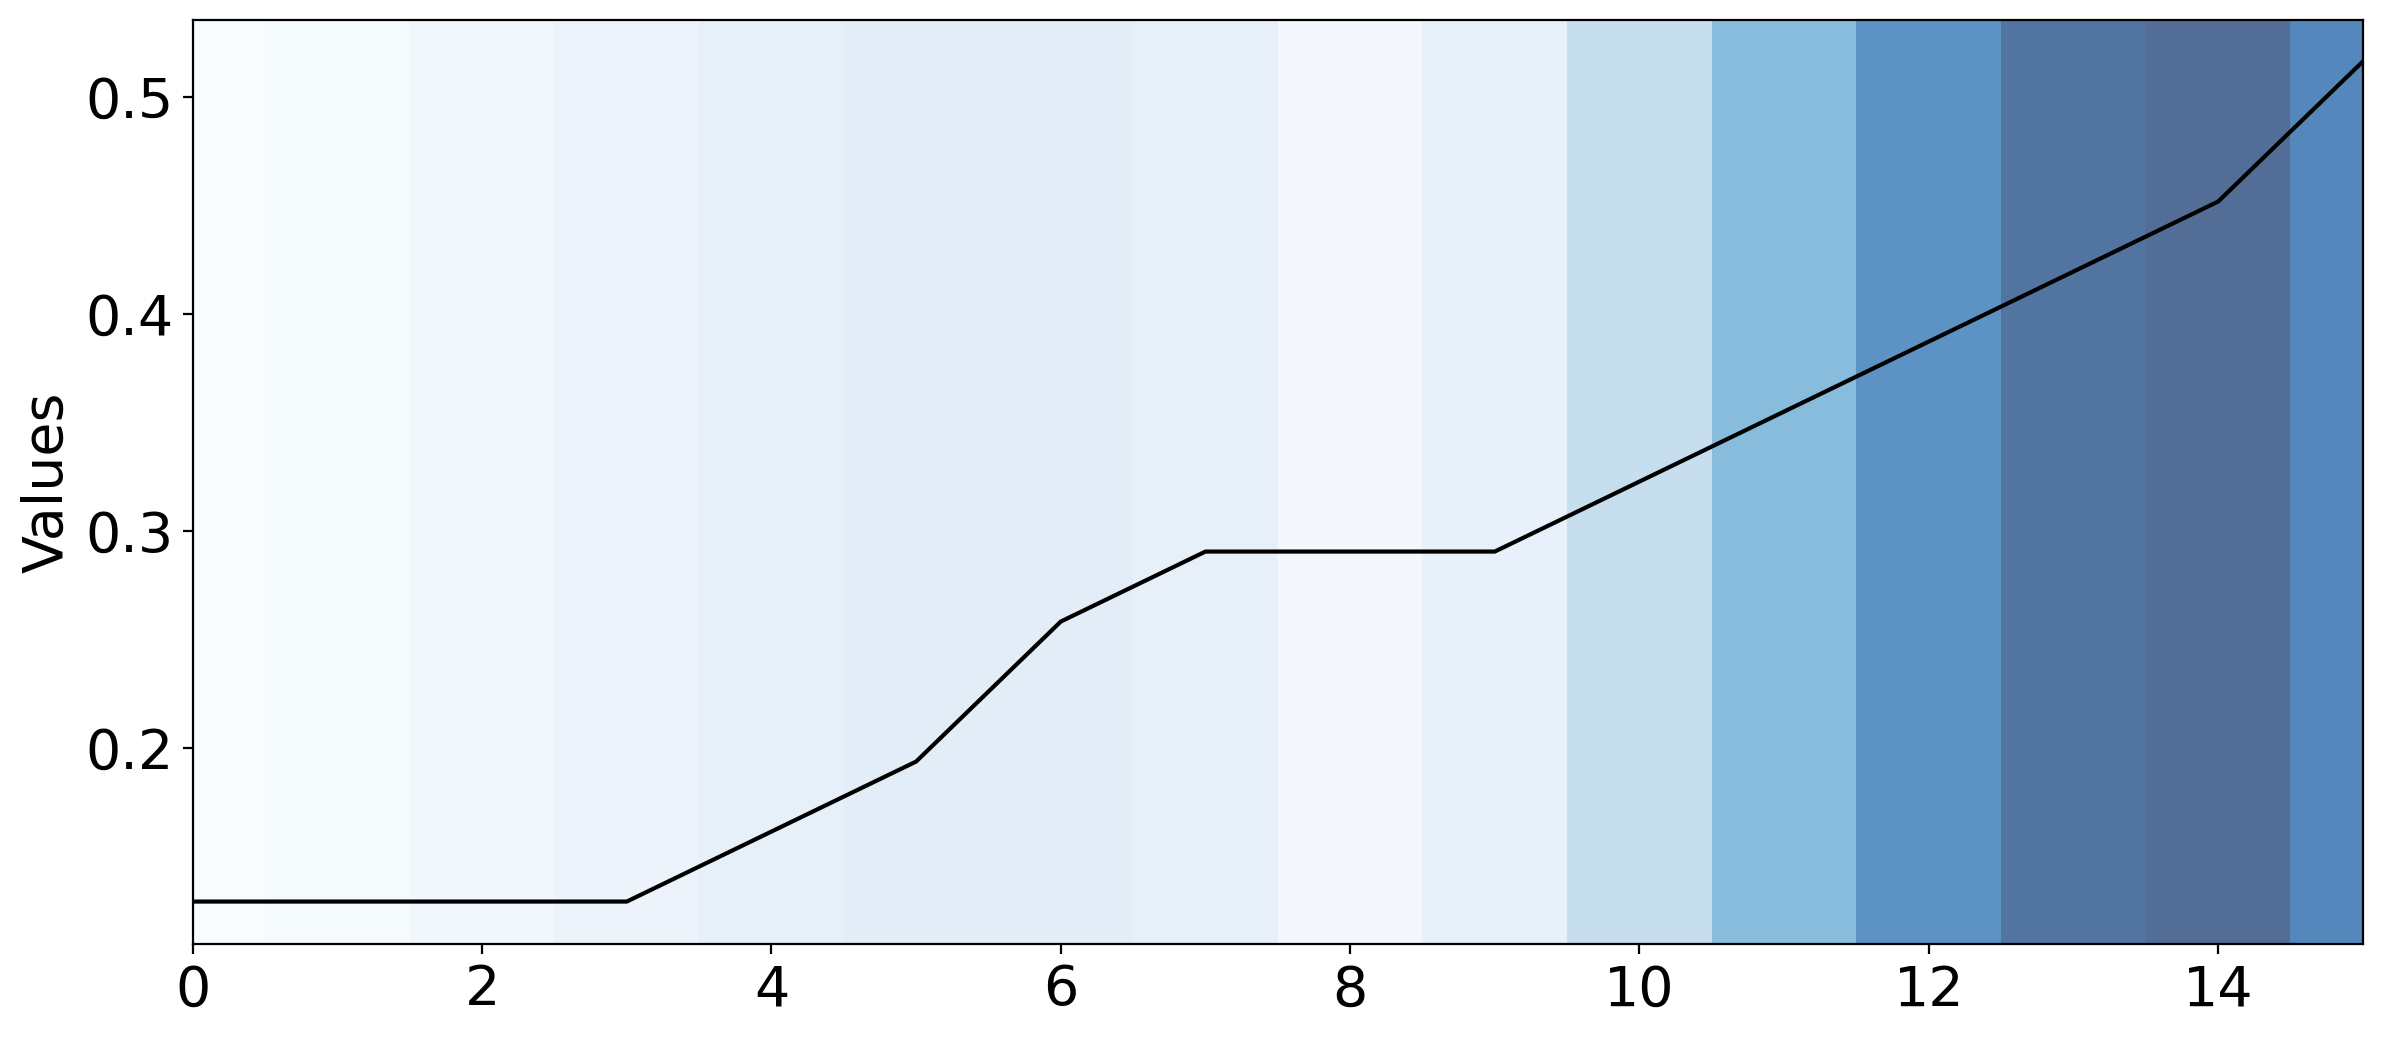

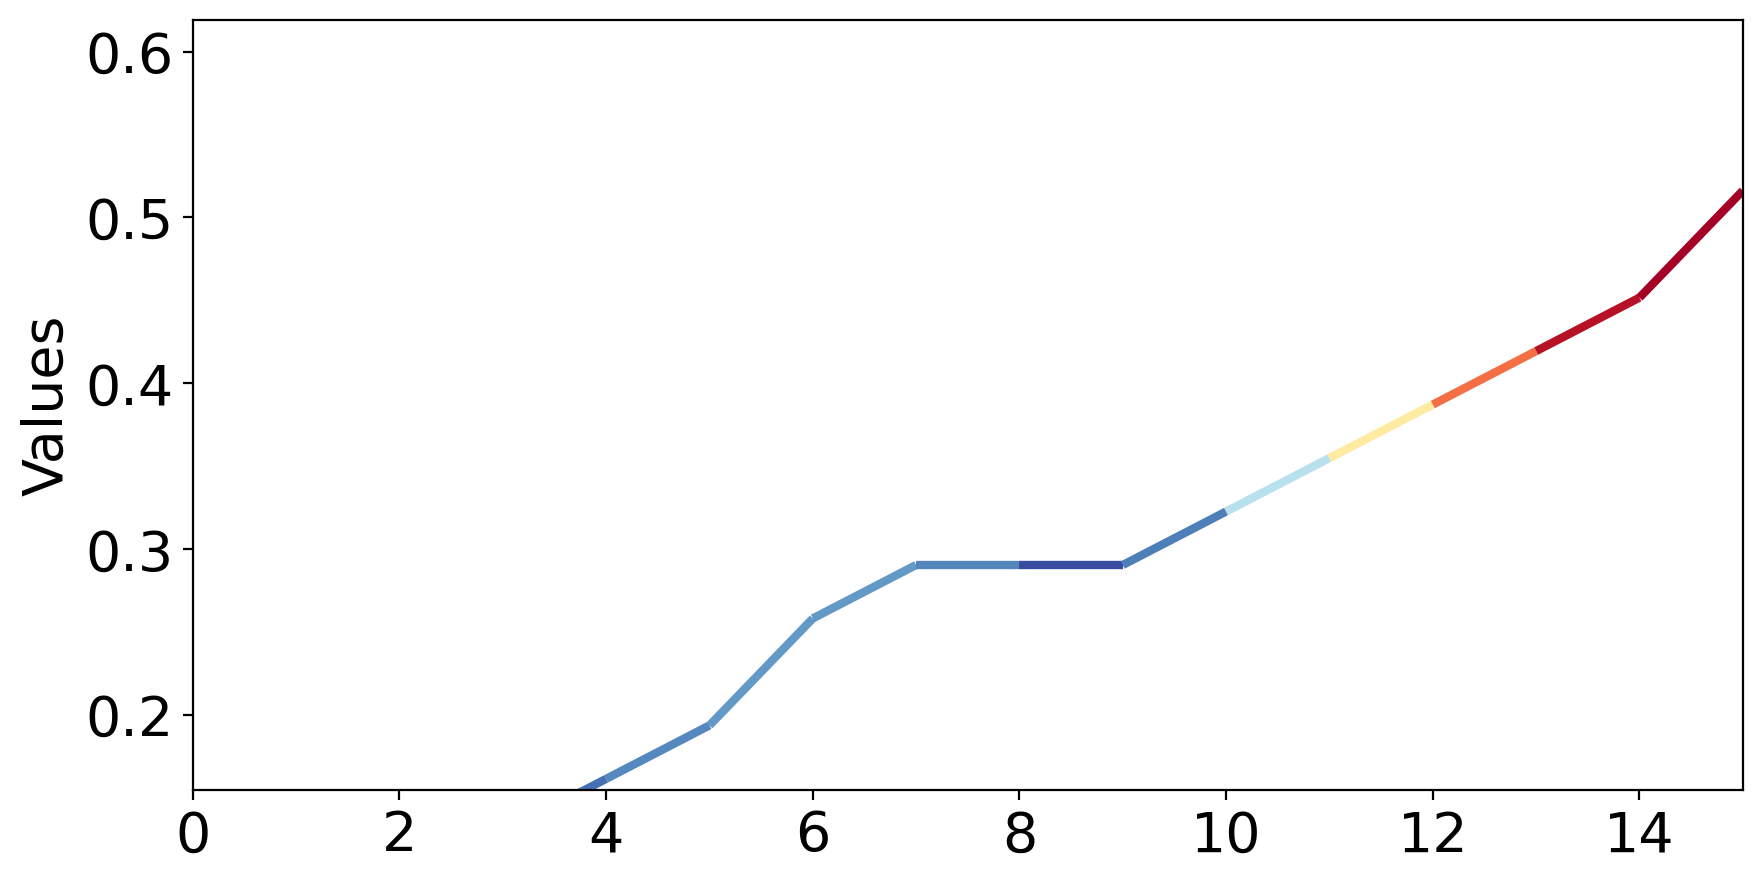

In [ ]:
attribution(0)

<ipython-input-196-e0a14fc56cfd>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(testX[datapoint])
/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


tensor([[[0.0017],
         [0.0075],
         [0.0165],
         [0.0277],
         [0.0389],
         [0.0467],
         [0.0471],
         [0.0361],
         [0.0108],
         [0.0296],
         [0.0828],
         [0.1422],
         [0.1956],
         [0.2279],
         [0.2256],
         [0.1830]]], device='cuda:0')


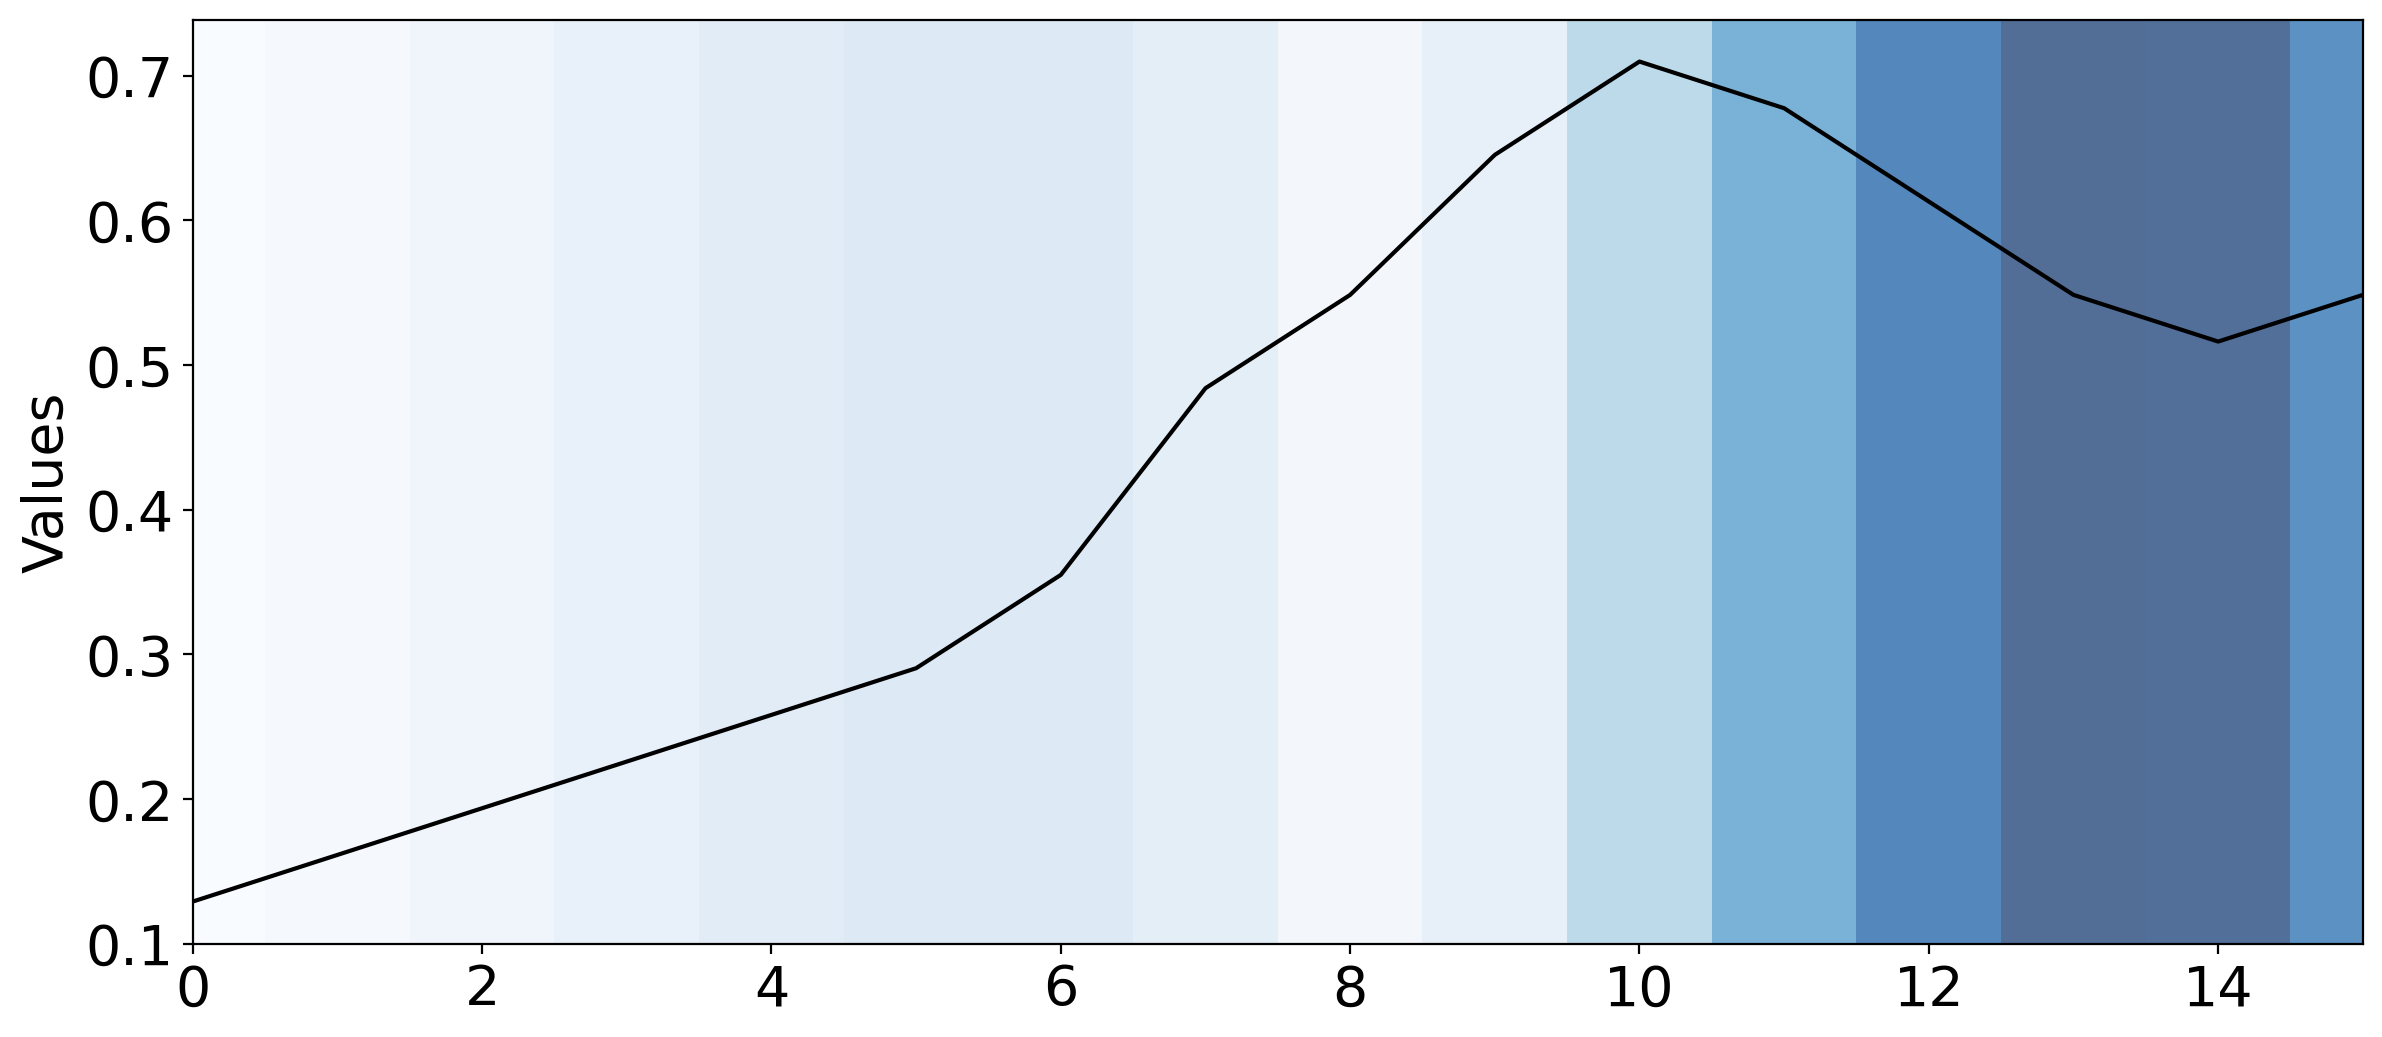

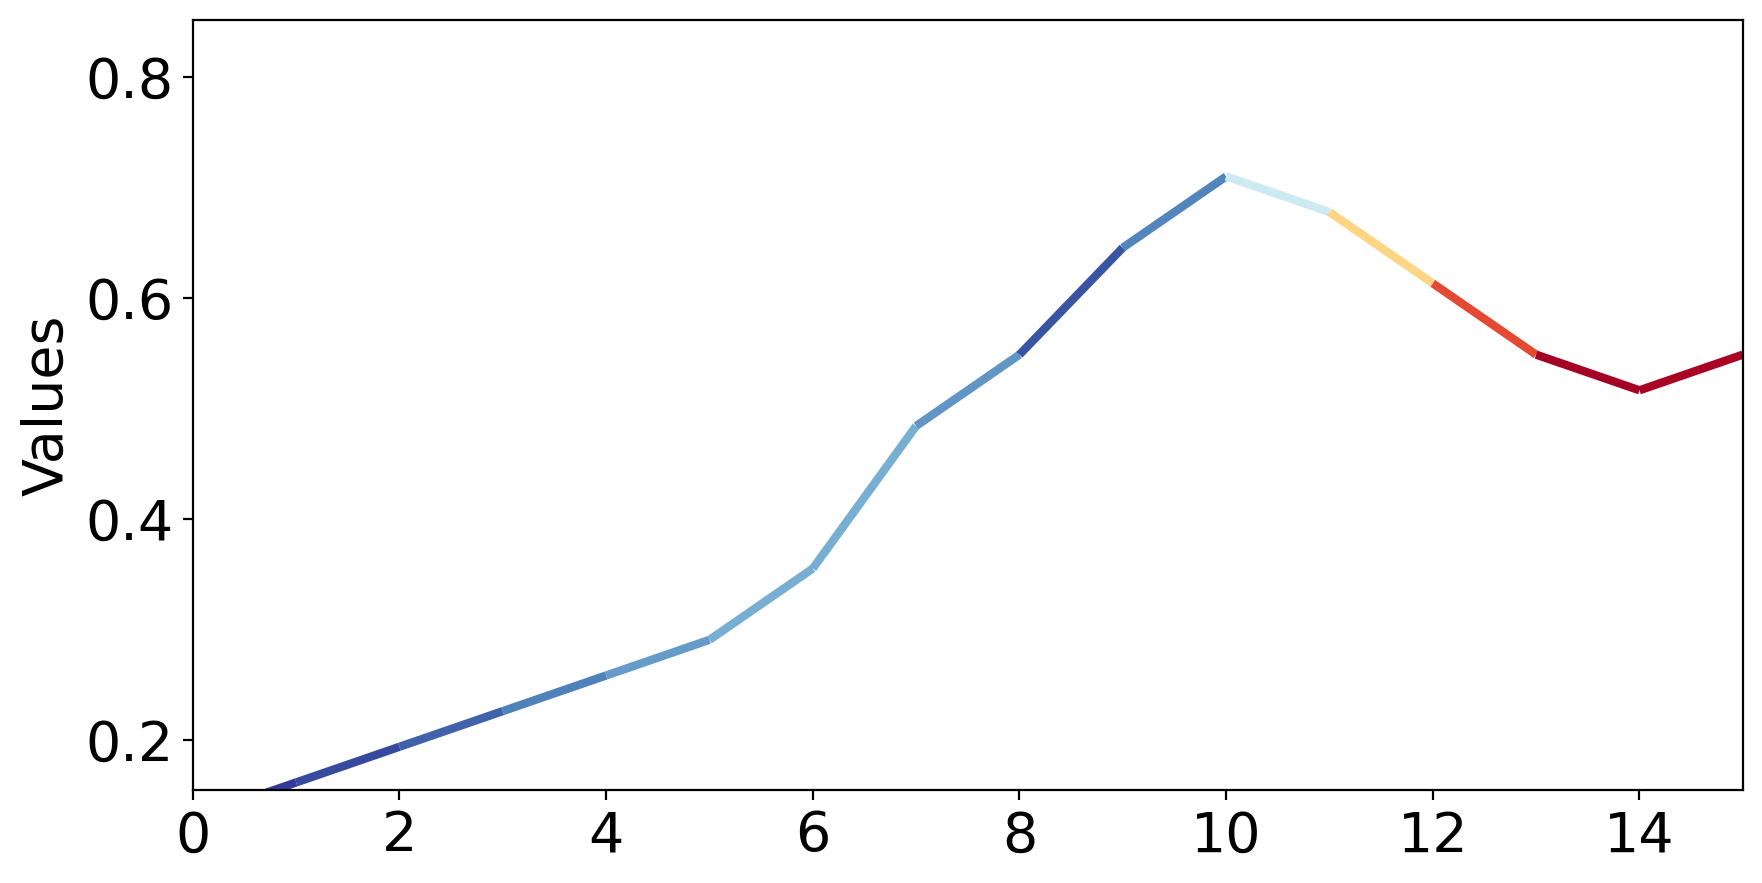

In [ ]:
attribution(2)